# Build Neural Linear Bandits with per-arm features

**Exploring linear and nonlinear** (e.g., those with neural network-based value functions) bandit methods for recommendations using TF-Agents

> Neural linear bandits provide a nice way to leverage the representation power of deep learning and the bandit approach for uncertainty measure and efficient exploration

## Notes

### Why generalize bandits to neural network models?

* NeuralLinear Bandits are linear contextual bandits use the last layer representation of the neural network as the contextual features
* NeuralLinear works well [paper](https://arxiv.org/pdf/1802.09127.pdf)
* Decouples representation learning and uncertainty estimation
* Computationally inexpensive 
* Achieves superior performance on multiple datasets

### Arm features

* In some bandits use cases, each arm has its own features. For example, in movie recommendation problems, the user features play the role of the context and the movies play the role of the arms (aka actions) 
* Each movie has its own features, such as `text description`, `metadata`, `trailer content` features and so on

These problems are often referred to as `arm features problems`

### Methods in this notebook:

* [global_and_arm_feature_networks](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network) to preprocess user (global) and item (per-arm) features, and output rewards
* `EncodingNetwork` to define a mapping of pre-processing layers to apply to a network's input 
* `ActorNetworks` to learn a mapping from observations to actions. These networks are usually used by our policies to generate actions

### references

**TF-Agent tutorials:**

(1) [Multi-Armed Bandits with Per-Arm Features](https://www.tensorflow.org/agents/tutorials/per_arm_bandits_tutorial)

* step-by-step guide on how to use the TF-Agents library for contextual bandits problems where the actions (arms) have their own features, such as a list of movies represented by features (genre, year of release, ...)

(2) [Networks](https://www.tensorflow.org/agents/tutorials/8_networks_tutorial)

* define custom networks for your agents
* The networks help us define the model that is trained by agents

(3) [Ranking](https://www.tensorflow.org/agents/tutorials/ranking_tutorial)

* ranking algorithms implemented as part of the TF-Agents Bandits library 
* In a ranking problem, in every iteration an agent is presented with a set of items, and is tasked with ranking some or all of them to a list
* This ranking decision then receives some form of feedback (maybe a user does or does not click on one or more of the selected items for example)
* The goal of the agent is to optimize some metric/reward with the goal of making better decisions over time

# setup notebook environment

In [621]:
# !pwd

In [1]:
import os

root_path = '/home/jupyter/tf_vertex_agents/04-perarm-features-bandit'
os.chdir(root_path)
os.getcwd()

'/home/jupyter/tf_vertex_agents/04-perarm-features-bandit'

In [2]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.26.0


## Load env config

* use the prefix from `00-env-setup`

In [1713]:
PREFIX = 'mabv1'

In [4]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "mabv1"
VERSION                  = "v1"

BUCKET_NAME              = "mabv1-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://mabv1-hybrid-vertex-bucket/data"
BUCKET_URI               = "gs://mabv1-hybrid-vertex-bucket"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "hybrid-vertex.movielens_dataset_mabv1"
BIGQUERY_TABLE_ID        = "hybrid-vertex.movielens_dataset_mabv1.training_dataset"

REPO_DOCKER_PATH_PREFIX  = "src"
RL_SUB_DIR               = "per_arm_rl"



## imports

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tf_agents.agents import TFAgent

from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network

# GPU
from numba import cuda 
import gc

# my project
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

### detect GPUs & reset devices

In [7]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
    
# gpus

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
device = cuda.get_current_device()
device.reset()
gc.collect()

19

### Initialize Google Cloud SDK Clients

In [11]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### Read TF Records

In [12]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [13]:
train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/val'): # tmp TODO - "train"
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://mabv1-hybrid-vertex-bucket/data/val/ml-ratings-100k-val.tfrecord']

In [14]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'211'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([874948475])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'346'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'other'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


### get vocab

**TODO:** 
* streamline vocab calls

In [15]:
GENERATE_VOCABS = False
print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

VOCAB_SUBDIR   = "vocabs"
VOCAB_FILENAME = "vocab_dict.pkl"

GENERATE_VOCABS: False


In [16]:
if not GENERATE_VOCABS:

    EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
    print(f"Downloading vocab...")
    
    os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
    print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

    filehandler = open(VOCAB_FILENAME, 'rb')
    vocab_dict = pkl.load(filehandler)
    filehandler.close()
    
    for key in vocab_dict.keys():
        pprint(key)

Downloaded vocab from: gs://mabv1-hybrid-vertex-bucket/vocabs/vocab_dict.pkl

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


# Per-Arm Bandits

In [17]:
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

nest = tf.nest

In [18]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 4
MV_EMBEDDING_SIZE      = 8 #32

### global preprcoessing layers

In [19]:
# global_inputs = []
# global_features = []

#### user ID

In [20]:
user_id_input_layer = tf.keras.Input(
    name="user_id",
    shape=(1,),
    dtype=tf.string
)

user_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_id'],
)(user_id_input_layer)

user_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_id_lookup)

user_id_embedding = tf.reduce_sum(user_id_embedding, axis=-2)

# global_inputs.append(user_id_input_layer)
# global_features.append(user_id_embedding)

In [21]:
test_user_id_model = tf.keras.Model(inputs=user_id_input_layer, outputs=user_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_id"])
    print(test_user_id_model(x["user_id"]))

tf.Tensor([b'346'], shape=(1,), dtype=string)
tf.Tensor([[-0.02599    -0.03078079  0.03106076  0.00133444]], shape=(1, 4), dtype=float32)


#### user AGE

In [22]:
user_age_input_layer = tf.keras.Input(
    name="bucketized_user_age",
    shape=(1,),
    dtype=tf.float32
)

user_age_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['bucketized_user_age'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(user_age_input_layer)

user_age_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['bucketized_user_age']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_age_lookup)

user_age_embedding = tf.reduce_sum(user_age_embedding, axis=-2)

# global_inputs.append(user_age_input_layer)
# global_features.append(user_age_embedding)

In [23]:
test_user_age_model = tf.keras.Model(inputs=user_age_input_layer, outputs=user_age_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["bucketized_user_age"])
    print(test_user_age_model(x["bucketized_user_age"]))

tf.Tensor([25.], shape=(1,), dtype=float32)
tf.Tensor([[ 0.02207417 -0.02917665  0.02782809 -0.02822751]], shape=(1, 4), dtype=float32)


#### user OCC

In [24]:
user_occ_input_layer = tf.keras.Input(
    name="user_occupation_text",
    shape=(1,),
    dtype=tf.string
)

user_occ_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_occupation_text'],
)(user_occ_input_layer)

user_occ_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_occ_lookup)

user_occ_embedding = tf.reduce_sum(user_occ_embedding, axis=-2)

# global_inputs.append(user_occ_input_layer)
# global_features.append(user_occ_embedding)

In [25]:
test_user_occ_model = tf.keras.Model(inputs=user_occ_input_layer, outputs=user_occ_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_occupation_text"])
    print(test_user_occ_model(x["user_occupation_text"]))

tf.Tensor([b'other'], shape=(1,), dtype=string)
tf.Tensor([[-0.04523091  0.0495333  -0.01482558 -0.04208376]], shape=(1, 4), dtype=float32)


#### user Timestamp

In [26]:
user_ts_input_layer = tf.keras.Input(
    name="timestamp",
    shape=(1,),
    dtype=tf.int64
)

user_ts_lookup = tf.keras.layers.Discretization(
    vocab_dict['timestamp_buckets'].tolist()
)(user_ts_input_layer)

user_ts_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['timestamp_buckets'].tolist()) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_ts_lookup)

user_ts_embedding = tf.reduce_sum(user_ts_embedding, axis=-2)

# global_inputs.append(user_ts_input_layer)
# global_features.append(user_ts_embedding)

In [27]:
test_user_ts_model = tf.keras.Model(inputs=user_ts_input_layer, outputs=user_ts_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["timestamp"])
    print(test_user_ts_model(x["timestamp"]))

tf.Tensor([874948475], shape=(1,), dtype=int64)
tf.Tensor([[ 0.00741076 -0.04264941  0.00693322 -0.03396516]], shape=(1, 4), dtype=float32)


### create `global_context_sampling_fn()`

In [29]:
# get_user_id_emb_model
# get_user_age_emb_model
# get_user_occ_emb_model
# get_ts_emb_model


In [30]:
def global_context_sampling_fn():
    """
    This function generates a single global observation vector.
    """
    # for x in train_dataset.take(1).as_numpy_iterator():
    for x in train_dataset.batch(1).take(1):
        user_id_value = x['user_id']
        user_age_value = x['bucketized_user_age']
        user_occ_value = x['user_occupation_text']
        user_ts_value = x['timestamp']
        
        _id = test_user_id_model(user_id_value)
        _age = test_user_age_model(user_age_value)
        _occ = test_user_occ_model(user_occ_value)
        _ts = test_user_ts_model(user_ts_value)
        
        # # tmp - insepct numpy() values
        # print(_id.numpy()) #[0])
        # print(_age.numpy()) #[0])
        # print(_occ.numpy()) #[0])
        # print(_ts.numpy()) #[0])
        
        # to numpy array
        _id = np.array(_id.numpy()[0])
        _age = np.array(_age.numpy()[0])
        _occ = np.array(_occ.numpy()[0])
        _ts = np.array(_ts.numpy()[0])
        
        concat = np.concatenate(
            [_id, _age, _occ, _ts], axis=-1
        ).astype(np.float32)
        
        return concat

In [31]:
global_context_sampling_fn()

array([-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
       -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
       -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
       -0.03396516], dtype=float32)

In [32]:
GLOBAL_DIM = 40
GLOBAL_BOUND = 10

def test_global_context_sampling_fn():
    """This function generates a single global observation vector."""
    return np.random.randint(
      -GLOBAL_BOUND, GLOBAL_BOUND, [GLOBAL_DIM]).astype(np.float32)

In [33]:
test_global_context_sampling_fn()

array([  3., -10.,   5.,   4.,   5.,  -8.,  -3.,   4.,  -8.,  -8.,  -3.,
        -3.,   6.,  -6.,   5.,  -7.,   5.,   4.,   7.,   9.,   1.,   6.,
        -3.,  -1., -10.,  -2.,  -9.,  -3.,  -2.,  -1.,   5.,  -8.,   9.,
        -3.,   9., -10.,   2.,   6.,  -1.,  -9.], dtype=float32)

### arm preprocessing layers

#### movie ID

In [34]:
mv_id_input_layer = tf.keras.Input(
    name="movie_id",
    shape=(1,),
    dtype=tf.string
)

mv_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['movie_id'],
)(mv_id_input_layer)

mv_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_id_lookup)

mv_id_embedding = tf.reduce_sum(mv_id_embedding, axis=-2)

# arm_inputs.append(mv_id_input_layer)
# arm_features.append(mv_id_embedding)

In [35]:
test_mv_id_model = tf.keras.Model(inputs=mv_id_input_layer, outputs=mv_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_id"])
    print(test_mv_id_model(x["movie_id"]))

tf.Tensor([b'211'], shape=(1,), dtype=string)
tf.Tensor(
[[-0.02780459 -0.00370889 -0.02864446 -0.02917221 -0.01603731  0.02465415
   0.01583499 -0.03253644]], shape=(1, 8), dtype=float32)


#### movie genre

In [36]:
mv_genre_input_layer = tf.keras.Input(
    name="movie_genres",
    shape=(1,),
    dtype=tf.float32
)

mv_genre_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_genres'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(mv_genre_input_layer)

mv_genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_genres']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_genre_lookup)

mv_genre_embedding = tf.reduce_sum(mv_genre_embedding, axis=-2)

# arm_inputs.append(mv_genre_input_layer)
# arm_features.append(mv_genre_embedding)

In [37]:
test_mv_gen_model = tf.keras.Model(inputs=mv_genre_input_layer, outputs=mv_genre_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_genres"])
    print(test_mv_gen_model(x["movie_genres"]))

tf.Tensor([[4]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[ 0.03956462  0.04351255  0.01470714  0.04936441  0.01360733 -0.0412104
   0.02928157  0.01699198]], shape=(1, 8), dtype=float32)


### create `arm_context_sampling_fn()`

In [38]:
def per_arm_context_sampling_fn():
    """
    This function generates a single per-arm observation vector
    """
    for x in train_dataset.batch(1).take(1):
        mv_id_value = x['movie_id']
        mv_gen_value = x['movie_genres'][0]
        
        _mid = test_mv_id_model(mv_id_value)
        _mgen = test_mv_gen_model(mv_gen_value)
        
        # to numpy array
        _mid = np.array(_mid.numpy()[0])
        _mgen = np.array(_mgen.numpy()[0])
        
        # print(_mid)
        # print(_mgen)
        
        concat = np.concatenate([_mid, _mgen], axis=-1).astype(np.float32)
        
        return concat

In [39]:
per_arm_context_sampling_fn()

array([-0.02780459, -0.00370889, -0.02864446, -0.02917221, -0.01603731,
        0.02465415,  0.01583499, -0.03253644,  0.03956462,  0.04351255,
        0.01470714,  0.04936441,  0.01360733, -0.0412104 ,  0.02928157,
        0.01699198], dtype=float32)

## define reward function

In [40]:
# JT - TODO

# from tf_agents.trajectories import time_step as ts
# from tf_agents.trajectories import trajectory
# # from tf_agents.typing import types

# discounts = tf.ones((BATCH_SIZE,), dtype=tf.float32)
# rewards = tf.ones((BATCH_SIZE,), dtype=tf.float32)
# actions = tf.ones((BATCH_SIZE,), dtype=tf.float32)

# next_step_types = tf.ones((BATCH_SIZE,), dtype=tf.int32) * ts.StepType.MID

# step_types = tf.concat([[ts.StepType.FIRST], next_step_types[1:]], axis=0)

# traj = trajectory.Trajectory(
#     step_type=step_types,
#     observation=observation, #obs_tensor_spec,
#     action=actions,
#     policy_info=(),
#     next_step_type=next_step_types,
#     reward=rewards,
#     discount=discounts
# )
# traj

In [41]:
GLOBAL_DIM = global_context_sampling_fn()
GLOBAL_DIM = GLOBAL_DIM.shape[0]
print(GLOBAL_DIM)

PER_ARM_DIM = per_arm_context_sampling_fn()
PER_ARM_DIM = PER_ARM_DIM.shape[0]
print(PER_ARM_DIM)

16
16


In [90]:
PARAM_BOUND = 5 

# should be similar to
reward_param = list(np.random.randint(-PARAM_BOUND, PARAM_BOUND, [GLOBAL_DIM + PER_ARM_DIM]))
print(len(reward_param))
# reward_param

32


In [94]:
test_global_out = global_context_sampling_fn()
test_arm_out = per_arm_context_sampling_fn()

x_x = np.concatenate([test_global_out, test_arm_out], axis=-1)
# x_x
mu = np.dot(x_x, reward_param)
mu

-0.24167780205607414

In [95]:
reward_param = list(np.ones(32))
print(len(reward_param))

mu = np.dot(x_x, reward_param)
mu

32


-0.07835058681666851

In [88]:
VARIANCE = 100.0 

def linear_normal_reward_fn(x):
    """This function generates a reward from the concatenated global and per-arm observations."""
    mu = np.dot(x, reward_param)
    return np.random.normal(mu, VARIANCE)

In [89]:
linear_normal_reward_fn(x_x)

-46.9599440925143

In [47]:
# def _get_rewards(element):
#     """Calculates reward for the actions."""

#     def _calc_reward(x):
#         """Calculates reward for a single action."""
#         r0 = lambda: tf.constant(0.0)
#         r1 = lambda: tf.constant(-10.0)
#         r2 = lambda: tf.constant(2.0)
#         r3 = lambda: tf.constant(3.0)
#         r4 = lambda: tf.constant(4.0)
#         r5 = lambda: tf.constant(10.0)
#         c1 = tf.equal(x, 1.0)
#         c2 = tf.equal(x, 2.0)
#         c3 = tf.equal(x, 3.0)
#         c4 = tf.equal(x, 4.0)
#         c5 = tf.equal(x, 5.0)
#         return tf.case([(c1, r1), (c2, r2), (c3, r3),(c4, r4),(c5, r5)], default=r0, exclusive=True)

#     return tf.map_fn(
#         fn=_calc_reward, 
#         elems=element['user_rating'], 
#         dtype=tf.float32
#     )

In [48]:
# for x in train_dataset.batch(1).take(3):
#     print(f"Rating: {x['user_rating']}")
#     print(f"Reward: {_get_rewards(x)}") #["user_rating"]))

# ## output ####
# Rating: [4.]
# Reward: [4.]
# Rating: [4.]
# Reward: [4.]
# Rating: [1.]
# Reward: [-10.]

## define environment

`num_actions_fn`:
* a function that outputs a single integer specifying the number of actions for a given time step. 
* The number of actions will be encoded in the observation by the feature key `num_actions`

In [49]:
NUM_ACTIONS = 10
BATCH_SIZE = 20

# num_actions_fn = None
num_actions_fn = lambda: NUM_ACTIONS

In [50]:
per_arm_py_env = p_a_env.StationaryStochasticPerArmPyEnvironment(
    global_context_sampling_fn = global_context_sampling_fn,
    arm_context_sampling_fn = per_arm_context_sampling_fn,
    max_num_actions = NUM_ACTIONS,
    reward_fn = linear_normal_reward_fn, # _get_rewards
    num_actions_fn = num_actions_fn,
    batch_size=BATCH_SIZE
)
per_arm_tf_env = tf_py_environment.TFPyEnvironment(per_arm_py_env)

In [51]:
print('observation spec: ', per_arm_tf_env.observation_spec())

observation spec:  {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None), 'num_actions': BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(1), maximum=array(10))}


In [52]:
print('reward_spec: ', per_arm_tf_env.reward_spec())

reward_spec:  TensorSpec(shape=(), dtype=tf.float32, name='reward')


In [53]:
print('\nAn observation: ', per_arm_tf_env.reset().observation)


An observation:  {'global': <tf.Tensor: shape=(20, 16), dtype=float32, numpy=
array([[-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
        -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
        -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
        -0.03396516],
       [-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
        -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
        -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
        -0.03396516],
       [-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
        -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
        -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
        -0.03396516],
       [-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
        -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
        -0.01482558, -0.04208376,  0.00741076, -0.04

In [54]:
action = tf.zeros(BATCH_SIZE, dtype=tf.int32)
time_step = per_arm_tf_env.step(action)
print('\nRewards after taking an action: ', time_step.reward)


Rewards after taking an action:  tf.Tensor(
[-150.27821   134.48189  -297.2999   -140.62787     6.723917   84.13467
    0.922849  -36.420517  -20.886211   -7.858317   10.700291  -92.6265
  -79.65316   -64.81762    17.944258 -147.62914    77.474724   62.227337
 -102.064545  191.07434 ], shape=(20,), dtype=float32)


## The Agent

**Note** that contextual bandits form a special case of RL, where the actions taken by the agent do not alter the state of the environment 

> “Contextual” refers to the fact that the agent chooses among a set of actions while having knowledge of the context (environment observation)

### agent types

**Possible Agent Types:**

```
AGENT_TYPE = ['LinUCB', 'LinTS', 'epsGreedy', 'NeuralLinUCB']
```

**LinearUCBAgent:** (`LinUCB`)
* An agent implementing the Linear UCB bandit algorithm
* (whitepaper) [A contextual bandit approach to personalized news recommendation](https://arxiv.org/abs/1003.0146)
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent/LinearUCBAgent)

**LinearThompsonSamplingAgent:** (`LinTS`)
* Implements the Linear Thompson Sampling Agent from the paper: [Thompson Sampling for Contextual Bandits with Linear Payoffs](https://arxiv.org/abs/1209.3352)
* the agent maintains two parameters `weight_covariances` and `parameter_estimators`, and updates them based on experience.
* The inverse of the weight covariance parameters are updated with the outer product of the observations using the Woodbury inverse matrix update, while the parameter estimators are updated by the reward-weighted observation vectors for every action
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/linear_thompson_sampling_agent/LinearThompsonSamplingAgent)

**NeuralEpsilonGreedyAgent:** (`epsGreedy`) 
* A neural network based epsilon greedy agent
* This agent receives a neural network that it trains to predict rewards
* The action is chosen greedily with respect to the prediction with probability `1 - epsilon`, and uniformly randomly with probability epsilon
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_epsilon_greedy_agent/NeuralEpsilonGreedyAgent)

**NeuralLinUCBAgent:** (`NeuralLinUCB`)
* An agent implementing the LinUCB algorithm on top of a neural network
* `ENCODING_DIM` is the output dimension of the encoding network 
> * This output will be used by either a linear reward layer and epsilon greedy exploration, or by a LinUCB logic, depending on the number of training steps executed so far
* `EPS_PHASE_STEPS` is the number training steps to run for training the encoding network before switching to `LinUCB`
> * If negative, the encoding network is assumed to be already trained
> * If the number of steps is less than or equal to `EPS_PHASE_STEPS`, `epsilon greedy` is used, otherwise `LinUCB`
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_linucb_agent/NeuralLinUCBAgent)

### network types

Which network architecture to use for the `epsGreedy` or `NeuralLinUCB` agents

```
NETWORK_TYPE = ['commontower', 'dotproduct']
```

**GlobalAndArmCommonTowerNetwork:** (`commontower`)
* This network takes the output of the global and per-arm networks, and leads them through a common network, that in turn outputs reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
> * `COMMON_LAYERS` - Iterable of ints. Specifies the layers of the common tower
* The network produced by this function can be used either in `GreedyRewardPredictionPolicy`, or `NeuralLinUCBPolicy`
> * In the former case, the network must have `output_dim=1`, it is going to be an instance of `QNetwork`, and used in the policy as a reward prediction network
> * In the latter case, the network will be an encoding network with its output consumed by a reward layer or a `LinUCB` method. The specified `output_dim` will be the encoding dimension
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmCommonTowerNetwork)

**GlobalAndArmDotProductNetwork:** (`dotproduct`)
* This network calculates the **dot product** of the output of the global and per-arm networks and returns them as reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmDotProductNetwork)

### define agent and network (optional)

In [55]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 5
EPS_PHASE_STEPS = 1000

# ================================
# Agent's Preprocess Network
# ================================
NETWORK_TYPE    = "dotproduct" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    

GLOBAL_LAYERS   = [16, 4]
ARM_LAYERS      = [16, 4]
COMMON_LAYERS   = [4]

observation_and_action_constraint_splitter = None

print(f"AGENT_TYPE      : {AGENT_TYPE}")
print(f"NETWORK_TYPE    : {NETWORK_TYPE}")
print(f"AGENT_ALPHA     : {AGENT_ALPHA}")
print(f"EPSILON         : {EPSILON}")
print(f"LR              : {LR}")
print(f"ENCODING_DIM    : {ENCODING_DIM}")
print(f"EPS_PHASE_STEPS : {EPS_PHASE_STEPS}")
print(f"GLOBAL_LAYERS   : {GLOBAL_LAYERS}")
print(f"ARM_LAYERS      : {ARM_LAYERS}")
print(f"COMMON_LAYERS   : {COMMON_LAYERS}")

AGENT_TYPE      : epsGreedy
NETWORK_TYPE    : dotproduct
AGENT_ALPHA     : 0.1
EPSILON         : 0.01
LR              : 0.05
ENCODING_DIM    : 5
EPS_PHASE_STEPS : 1000
GLOBAL_LAYERS   : [16, 4]
ARM_LAYERS      : [16, 4]
COMMON_LAYERS   : [4]


In [56]:
from tf_agents.bandits.policies import policy_utilities

network = None

if AGENT_TYPE == 'LinUCB':
    agent = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=per_arm_tf_env.time_step_spec(),
        action_spec=per_arm_tf_env.action_spec(),
        alpha=AGENT_ALPHA,
        accepts_per_arm_features=True,
        dtype=tf.float32,
    )
elif AGENT_TYPE == 'LinTS':
    agent = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=per_arm_tf_env.time_step_spec(),
        action_spec=per_arm_tf_env.action_spec(),
        alpha=AGENT_ALPHA,
        observation_and_action_constraint_splitter=(
            observation_and_action_constraint_splitter
        ),
        accepts_per_arm_features=True,
        dtype=tf.float32,
    )
elif AGENT_TYPE == 'epsGreedy':
    obs_spec = per_arm_tf_env.observation_spec()
    if NETWORK_TYPE == 'commontower':
        network = global_and_arm_feature_network.create_feed_forward_common_tower_network(
            observation_spec = obs_spec, 
            global_layers = GLOBAL_LAYERS, 
            arm_layers = ARM_LAYERS, 
            common_layers = COMMON_LAYERS,
            # output_dim = 1
        )
    elif NETWORK_TYPE == 'dotproduct':
        network = global_and_arm_feature_network.create_feed_forward_dot_product_network(
            observation_spec = obs_spec, 
            global_layers = GLOBAL_LAYERS, 
            arm_layers = ARM_LAYERS
        )
    agent = neural_epsilon_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=per_arm_tf_env.time_step_spec(),
        action_spec=per_arm_tf_env.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        observation_and_action_constraint_splitter=(
            observation_and_action_constraint_splitter
        ),
        accepts_per_arm_features=True,
        emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
    )

elif AGENT_TYPE == 'NeuralLinUCB':
    obs_spec = per_arm_tf_env.observation_spec()
    network = (
        global_and_arm_feature_network.create_feed_forward_common_tower_network(
            observation_spec = obs_spec, 
            global_layers = GLOBAL_LAYERS, 
            arm_layers = ARM_LAYERS, 
            common_layers = COMMON_LAYERS,
            output_dim = ENCODING_DIM
        )
    )
    agent = neural_linucb_agent.NeuralLinUCBAgent(
        time_step_spec=per_arm_tf_env.time_step_spec(),
        action_spec=per_arm_tf_env.action_spec(),
        encoding_network=network,
        encoding_network_num_train_steps=EPS_PHASE_STEPS,
        encoding_dim=ENCODING_DIM,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        alpha=1.0,
        gamma=1.0,
        epsilon_greedy=EPSILON,
        accepts_per_arm_features=True,
        debug_summaries=True,
        summarize_grads_and_vars=True,
        emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
    )
    
print(f"Agent: {agent.name}\n")

if network:
    print(f"Network: {network.name}")

Agent: neural_epsilon_greedy_agent

Network: GlobalAndArmDotProductNetwork


In [57]:
pprint(agent.policy.trajectory_spec)

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None), 'num_actions': BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(1), maximum=array(10))}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(10,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'rewa

In [58]:
# observation_spec = per_arm_tf_env.observation_spec()
# time_step_spec = ts.time_step_spec(observation_spec)
# time_step_spec

In [59]:
# action_spec = tensor_spec.BoundedTensorSpec(
#     dtype=tf.int32, shape=(), minimum=0, maximum=NUM_ACTIONS - 1)

# action_spec

In [60]:
# agent = lin_ucb_agent.LinearUCBAgent(
#     time_step_spec=time_step_spec,
#     action_spec=action_spec,
#     accepts_per_arm_features=True
# )

# agent

## The flow of training data

In [61]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'num_actions': BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(1), maximum=array(10))}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(10,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 

In [62]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'num_actions': BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(1), maximum=array(10))}


In [63]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(16,), dtype=tf.float32, name=None)


## Defining the Regret Metric

In [64]:
def _all_rewards(observation, hidden_param):
    """Outputs rewards for all actions, given an observation."""
    hidden_param = tf.cast(hidden_param, dtype=tf.float32)
    global_obs = observation['global']
    per_arm_obs = observation['per_arm']
    num_actions = tf.shape(per_arm_obs)[1]
    tiled_global = tf.tile(
        tf.expand_dims(global_obs, axis=1), [1, num_actions, 1])
    concatenated = tf.concat([tiled_global, per_arm_obs], axis=-1)
    rewards = tf.linalg.matvec(concatenated, hidden_param)
    return rewards

def optimal_reward(observation, hidden_param):
    """Outputs the maximum expected reward for every element in the batch."""
    return tf.reduce_max(
        _all_rewards(observation, hidden_param), axis=1
    )

def optimal_action(observation, hidden_param):
    return tf.argmax(
        _all_rewards(observation, hidden_param), axis=1, output_type=tf.int32
    )

# works
# regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward)

# new
optimal_reward_fn = functools.partial(
    optimal_reward, hidden_param=reward_param
)
optimal_action_fn = functools.partial(
    optimal_action, hidden_param=reward_param
)

suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
    optimal_action_fn
)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)

metrics = [regret_metric, suboptimal_arms_metric]

## Training Loop

* train stationary env [example](https://github.com/418sec/agents/blob/master/tf_agents/bandits/agents/examples/v2/train_eval_per_arm_stationary_linear.py)
* train loop [src](https://github.com/418sec/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py)

`async_steps_per_loop`: 
* an optional integer for simulating offline or asynchronous training
* In each training loop iteration, the driver runs this many times, each executing `steps_per_loop` driver steps, and then the agent gets asynchronously trained over this many batches sampled from the replay buffer
* When unset or set to 1, the function performs synchronous training, where the agent gets trained on a single batch immediately after the driver runs.


**TODO**
* add checkpointer
* add ditribution strategy (GPU support)

In [65]:
from tf_agents.bandits.agents.examples.v2 import trainer

In [66]:
EXPERIMENT_NAME   = f'neural-linear-bandits-v1'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

LOG_DIR           = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/tb-logs"
ROOT_DIR          = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : neural-linear-bandits-v1
RUN_NAME          : run-20230808-035548
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/neural-linear-bandits-v1/run-20230808-035548/tb-logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/neural-linear-bandits-v1/run-20230808-035548/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/neural-linear-bandits-v1/run-20230808-035548/artifacts


In [68]:
import tensorflow as tf
from tf_agents.metrics import tf_metrics

from src.perarm_features import trainer_common as trainer_common

TRAINING_LOOPS = 25
STEPS_PER_LOOP = 2
drop_arm_feature_fn = None
ASYNC_STEPS_PER_LOOP = 1

In [69]:

# put these in trainer_common.py

# replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#     data_spec=agent.policy.trajectory_spec,
#     batch_size=BATCH_SIZE,
#     max_length=STEPS_PER_LOOP * ASYNC_STEPS_PER_LOOP
# )

# # `step_metric` records the number of individual rounds of bandit interaction;
# # that is, (number of trajectories) * batch_size.
# step_metric = tf_metrics.EnvironmentSteps()

# observers = [replay_buffer.add_batch, regret_metric, step_metric, suboptimal_arms_metric]

# driver = dynamic_step_driver.DynamicStepDriver(
#     env=per_arm_tf_env,
#     policy=agent.collect_policy,
#     num_steps=STEPS_PER_LOOP * BATCH_SIZE,
#     observers=observers
# )

In [70]:
#start the timer and training
start_time = time.time()

metric_results = trainer_common.train_perarm(
    agent = agent,
    # replay_buffer = replay_buffer,
    # driver = driver,
    environment = per_arm_tf_env,
    # step_metric = step_metric,
    num_iterations = TRAINING_LOOPS,
    steps_per_loop = STEPS_PER_LOOP,
    log_interval = 1,
    # regret_metric = regret_metric,
    log_dir=LOG_DIR,
    model_dir=ARTIFACTS_DIR,
    root_dir=ROOT_DIR,
    async_steps_per_loop = ASYNC_STEPS_PER_LOOP,
    resume_training_loops = False,
    get_replay_buffer_fn = None,
    get_training_loop_fn = None,
    training_data_spec_transformation_fn = None,
    additional_metrics = metrics
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

setting checkpoint_manager: gs://mabv1-hybrid-vertex-bucket/neural-linear-bandits-v1/run-20230808-035548/root/chkpoint
starting_loop: 0
starting train loop...
step = 0: loss = 8324.009765625; execution time: 1
step = 1: loss = 6709.85986328125; execution time: 1
step = 2: loss = 12530.330078125; execution time: 0
step = 3: loss = 9894.7001953125; execution time: 0
step = 4: loss = 8768.9697265625; execution time: 1
step = 5: loss = 7674.60009765625; execution time: 0
step = 6: loss = 13309.6201171875; execution time: 0
step = 7: loss = 6386.52001953125; execution time: 0
step = 8: loss = 9392.3798828125; execution time: 0
step = 9: loss = 14712.580078125; execution time: 0
step = 10: loss = 10188.759765625; execution time: 1
step = 11: loss = 6219.5498046875; execution time: 0
step = 12: loss = 7561.740234375; execution time: 0
step = 13: loss = 11981.4697265625; execution time: 0
step = 14: loss = 14318.349609375; execution time: 0
step = 15: loss = 13009.4296875; execution time: 0
st

### bandit eval

In [568]:
# len(metric_results['RegretMetric'])
# metric_results

In [71]:
for key in metric_results:
    print(key)

NumberOfEpisodes
AverageEpisodeLengthMetric
RegretMetric
SuboptimalArmsMetric
AverageReturnMetric


In [72]:
def plot(metric_results, metric_name):
    plt.plot(metric_results[metric_name])
    plt.ylabel(metric_name)
    plt.xlabel("Step")
    plt.title("{} versus Step".format(metric_name))

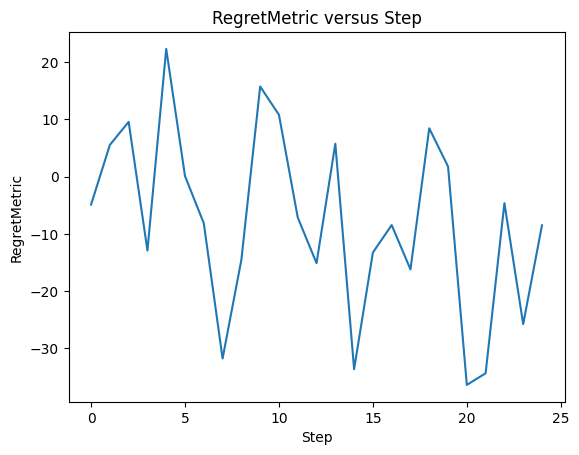

In [73]:
plot(metric_results, "RegretMetric")

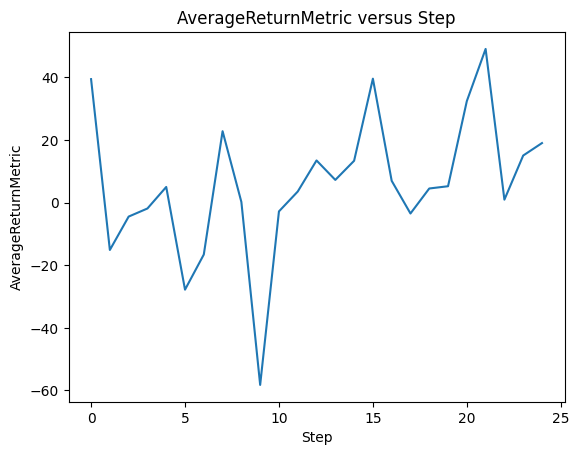

In [74]:
plot(metric_results, "AverageReturnMetric")

#### TensorBoard

In [75]:
# %load_ext tensorboard
%reload_ext tensorboard

In [76]:
%tensorboard --logdir=$LOG_DIR

### log experiment to Vertex

In [77]:
if not network:
    NETWORK_NAME = "None"
    GLOBAL_LAYERS = "None"
    ARM_LAYERS = "None"
    COMMON_LAYERS = "None"
    ENCODING_DIM = "None"
    EPS_PHASE_STEPS = "None"
else:
    NETWORK_NAME = network.name
    GLOBAL_LAYERS = GLOBAL_LAYERS
    ARM_LAYERS = ARM_LAYERS
    COMMON_LAYERS = COMMON_LAYERS
    ENCODING_DIM = ENCODING_DIM
    EPS_PHASE_STEPS = EPS_PHASE_STEPS

print(f"NETWORK_NAME    : {NETWORK_NAME}")
print(f"GLOBAL_LAYERS   : {GLOBAL_LAYERS}")
print(f"ARM_LAYERS      : {ARM_LAYERS}")
print(f"COMMON_LAYERS   : {COMMON_LAYERS}")
print(f"ENCODING_DIM    : {ENCODING_DIM}")
print(f"EPS_PHASE_STEPS : {EPS_PHASE_STEPS}")

NETWORK_NAME    : GlobalAndArmDotProductNetwork
GLOBAL_LAYERS   : [16, 4]
ARM_LAYERS      : [16, 4]
COMMON_LAYERS   : [4]
ENCODING_DIM    : 5
EPS_PHASE_STEPS : 1000


In [78]:
aiplatform.start_run(
    RUN_NAME
    # , tensorboard=TB_RESOURCE_NAME
    , resume=False
)

aiplatform.log_params(
    {
        "agent_type": agent.name,
        "network": NETWORK_NAME,
        "runtime": runtime_mins,
        "batch_size": BATCH_SIZE, 
        "training_loops": TRAINING_LOOPS,
        "steps_pre_loop": STEPS_PER_LOOP,
        # "rank_k": RANK_K,
        "num_actions": NUM_ACTIONS,
        "per_arm": "True",
        "global_lyrs": str(GLOBAL_LAYERS),
        "arm_lyrs": str(ARM_LAYERS),
        "common_lyrs": str(COMMON_LAYERS),
        "encoding_dim": ENCODING_DIM,
        "eps_steps": EPS_PHASE_STEPS,
    }
)

# gather the metrics for the last epoch to be saved in metrics
aiplatform.log_metrics(
    {
        "AverageReturnMetric" : float(metric_results["AverageReturnMetric"][-1])
        , "FinalRegretMetric" : float(metric_results["RegretMetric"][-1])
    }
)

aiplatform.end_run()

# Off-Policy training

In [1751]:
def _get_rewards(element):
    """Calculates reward for the actions."""

    def _calc_reward(x):
        """Calculates reward for a single action."""
        r0 = lambda: tf.constant(0.0)
        r1 = lambda: tf.constant(-10.0)
        r2 = lambda: tf.constant(2.0)
        r3 = lambda: tf.constant(3.0)
        r4 = lambda: tf.constant(4.0)
        r5 = lambda: tf.constant(10.0)
        c1 = tf.equal(x, 1.0)
        c2 = tf.equal(x, 2.0)
        c3 = tf.equal(x, 3.0)
        c4 = tf.equal(x, 4.0)
        c5 = tf.equal(x, 5.0)
        return tf.case([(c1, r1), (c2, r2), (c3, r3),(c4, r4),(c5, r5)], default=r0, exclusive=True)

    return tf.map_fn(
        fn=_calc_reward, 
        elems=element['user_rating'], 
        dtype=tf.float32
    )

In [1752]:
def _get_global_feature_list(input_features):
    """Return list of global features."""
    global_feature_names = ['user_id', 'bucketized_user_age', 'user_occupation_text', 'timestamp']
    global_features = []
    for global_feature in global_feature_names:
        if global_feature in input_features:
            global_features.append(input_features[global_feature])
        else:
            logging.error('Missing global feature %s', global_feature)
    return global_features

def _get_per_arm_feature_dict(input_features):
    """Returns a dictionary mapping feature key to per arm features."""
    per_arm_feature_names = ['movie_id', 'movie_genres']
    arm_features = {}
    for per_arm_feature in per_arm_feature_names:
        if per_arm_feature in input_features:
            arm_features[per_arm_feature] = input_features[per_arm_feature]
        else:
            logging.error('Missing per arm feature %s', per_arm_feature)
    return arm_features

def _add_outer_dimension(x):
    """Adds an extra outer dimension."""
    if isinstance(x, dict):
        for key, value in x.items():
            x[key] = tf.expand_dims(value, 1)
        return x
    return tf.expand_dims(x, 1)

#### tmp - debugging

In [1753]:
# for x in train_dataset.batch(1).take(1):
#     testy = _get_per_arm_feature_dict(x)

###    
# testz = _add_outer_dimension(testy)
# >>>>
# {'movie_id': <tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'211']], dtype=object)>,
#  'movie_genres': <tf.Tensor: shape=(1, 1, 1), dtype=int64, numpy=array([[[4]]])>}

### 
# testx = tensor_spec.add_outer_dim(
#     specs=testy,
#     dim=None
# )
# >>>>
# {'movie_id': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
#  'movie_genres': TensorSpec(shape=(None, 1, 1), dtype=tf.int64, name=None)}

#### tmp - debugging

```
InvalidArgumentError: Exception encountered when calling layer 'tf.math.reduce_sum' (type TFOpLambda).

{{function_node __wrapped__Sum_device_/job:localhost/replica:0/task:0/device:GPU:0}} Invalid reduction dimension (-2 for input with 1 dimension(s) [Op:Sum] name: 

Call arguments received by layer 'tf.math.reduce_sum' (type TFOpLambda):
  • input_tensor=tf.Tensor(shape=(4,), dtype=float32)
  • axis=-2
  • keepdims=False
  • name=None
```

In [1754]:
# # _id = test_user_id_model(user_id_value)
# # .batch(1)
# for x in train_dataset.take(1):
#     user_id_value = x['user_id']
#     print(user_id_value)
#     _id = test_user_id_model(user_id_value)
#     print(_id)
#     # XXX = tf.math.reduce_sum(_id, axis=-2)
#     # print(XXX)

## global and arm feature generators

In [1755]:
def _get_global_context_features(x):
    """
    This function generates a single global observation vector.
    """
    user_id_value = x['user_id']
    user_age_value = x['bucketized_user_age']
    user_occ_value = x['user_occupation_text']
    user_ts_value = x['timestamp']

    _id = test_user_id_model(user_id_value) # input_tensor=tf.Tensor(shape=(4,), dtype=float32)
    _age = test_user_age_model(user_age_value)
    _occ = test_user_occ_model(user_occ_value)
    _ts = test_user_ts_model(user_ts_value)

    # # tmp - insepct numpy() values
    # print(_id.numpy()) #[0])
    # print(_age.numpy()) #[0])
    # print(_occ.numpy()) #[0])
    # print(_ts.numpy()) #[0])

    # to numpy array
    _id = np.array(_id.numpy()[0])
    _age = np.array(_age.numpy()[0])
    _occ = np.array(_occ.numpy()[0])
    _ts = np.array(_ts.numpy()[0])

    concat = np.concatenate(
        [_id, _age, _occ, _ts], axis=-1 # -1
    ).astype(np.float32)

    return concat

def _get_per_arm_features(x):
    """
    This function generates a single per-arm observation vector
    """
    mv_id_value = x['movie_id']
    mv_gen_value = x['movie_genres'][0]

    _mid = test_mv_id_model(mv_id_value)
    _mgen = test_mv_gen_model(mv_gen_value)

    # to numpy array
    _mid = np.array(_mid.numpy()[0])
    _mgen = np.array(_mgen.numpy()[0])

    # print(_mid)
    # print(_mgen)

    concat = np.concatenate(
        [_mid, _mgen], axis=-1 # -1
    ).astype(np.float32)
    # concat = tf.concat([_mid, _mgen], axis=-1).astype(np.float32)

    return concat

In [1756]:
for x in train_dataset.batch(1).take(1):
    test_globals = _get_global_context_features(x)

print(test_globals.shape)
test_globals

(16,)


array([-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
       -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
       -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
       -0.03396516], dtype=float32)

In [1759]:
for x in train_dataset.batch(1).take(1):
    test_arms = _get_per_arm_features(x)

print(test_arms.shape)
test_arms

(16,)


array([-0.02780459, -0.00370889, -0.02864446, -0.02917221, -0.01603731,
        0.02465415,  0.01583499, -0.03253644,  0.03956462,  0.04351255,
        0.01470714,  0.04936441,  0.01360733, -0.0412104 ,  0.02928157,
        0.01699198], dtype=float32)

## trajectory function

* see [test example](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/policies/reward_prediction_policies_test.py#L309)
* see [create_per_arm_observation_spec src](https://github.com/tensorflow/agents/blob/master/tf_agents/specs/bandit_spec_utils.py#L39)

In [1760]:
HPARAMS = {
    "batch_size":8,
    "num_docs_to_rank":1,
    "model_type": "neural_epsilon_greedy",
    "network_type": 'commontower',
    "global_layers": [16,4],
    "per_arm_layers": [16,4],
    "common_layers": [4],
    "learning_rate": 0.05,
    "epsilon":0.01,
}

num_actions = HPARAMS['num_docs_to_rank']
# num_actions=tf.convert_to_tensor(num_actions, dtype=tf.int32)
print(num_actions)

1


[create_per_arm_observation_spec](https://github.com/tensorflow/agents/blob/master/tf_agents/specs/bandit_spec_utils.py#L39)
```
def create_per_arm_observation_spec(
    global_dim: int,
    per_arm_dim: int,
    max_num_actions: Optional[int] = None,
    add_num_actions_feature: bool = False,
) -> types.NestedTensorSpec:
  """Creates an observation spec with per-arm features and possibly action mask.

  Args:
    global_dim: (int) The global feature dimension.
    per_arm_dim: (int) The per-arm feature dimension.
    max_num_actions: If specified (int), this is the maximum number of actions
      in any sample, and the num_actions dimension of the per-arm features will
      be set to this number. The actual number of actions for a given sample can
      be lower than this parameter: it can be specified via the
      NUM_ACTIONS_FEATURE_KEY, or an action mask.
    add_num_actions_feature: (bool) whether to use the `num_actions` feature key
      to encode the number of actions per sample.

  Returns:
    A nested structure of observation spec.
  """
 ```

#### Debugging from test_script

* [src](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/policies/reward_prediction_policies_test.py)

In [1761]:
obs_spec = bandit_spec_utils.create_per_arm_observation_spec(GLOBAL_DIM, PER_ARM_DIM, num_actions) # 2,3,4
obs_spec

{'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)}

In [1762]:
time_step_spec = ts.time_step_spec(obs_spec)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [1763]:
action_spec = tensor_spec.BoundedTensorSpec((), tf.int32, 0, 3)
action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(3, dtype=int32))

In [ ]:
# reward_network = (
#     global_and_arm_feature_network.create_feed_forward_common_tower_network(
#         obs_spec, (4, 3), (3, 4), (4, 2)
#     )
# )

In [ ]:
    # policy = policy_class(
    #     time_step_spec,
    #     action_spec,
    #     reward_network=reward_network,
    #     accepts_per_arm_features=True,
    #     emit_policy_info=('predicted_rewards_mean',),
    # )
    # just from test script

In [1770]:
action_feature = tf.cast(
    tf.reshape(tf.random.shuffle(tf.range(256)), shape=[GLOBAL_DIM, num_actions, PER_ARM_DIM]), # 2, 4, 3
    dtype=tf.float32,
)
action_feature #- TODO - comeback

<tf.Tensor: shape=(16, 1, 16), dtype=float32, numpy=
array([[[232., 240., 215.,  59.,  25.,  31., 182., 198., 113., 242.,
          71.,   6.,  58., 179., 210., 185.]],

       [[ 62., 190., 141.,  75., 166., 255., 125., 118.,  78., 233.,
         183.,  68., 171., 114., 253., 228.]],

       [[  7., 252., 108.,   8., 105., 246.,  94.,  35.,  55., 112.,
         209., 207., 172.,   1.,  97.,  67.]],

       [[117., 149.,  42.,  39.,  37.,  98.,  61.,  50., 160., 214.,
         249., 167.,   4.,  85.,  95.,  45.]],

       [[203., 199.,  34.,  81.,  15., 181.,   2., 205.,  49.,  21.,
         103., 254., 236., 126.,  79.,   9.]],

       [[189., 229., 129.,  44.,  84., 213.,  69.,   5., 104., 110.,
          77., 212., 200., 100.,  17.,  41.]],

       [[ 87., 146., 148., 170.,  51.,  91.,  38.,  99., 115., 186.,
         238., 244., 122.,  18., 234., 151.]],

       [[169.,  54.,  80., 237., 132.,  53., 134.,  96.,  56., 226.,
          86., 127.,  46., 111., 131.,  16.]],

       [[14

In [1767]:
_test_observations = {
    bandit_spec_utils.GLOBAL_FEATURE_KEY: tf.constant(
        [[1, 2], [3, 4]], dtype=tf.float32
    ),
    bandit_spec_utils.PER_ARM_FEATURE_KEY: action_feature,
}

_test_observations

{'global': <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1., 2.],
        [3., 4.]], dtype=float32)>,
 'per_arm': <tf.Tensor: shape=(16, 1, 16), dtype=float32, numpy=
 array([[[214., 159.,  86.,  72.,  44., 218., 116., 162., 211.,  60.,
          244.,  80., 164.,  66., 215., 188.]],
 
        [[ 43., 243., 114.,  48.,  17., 172., 119., 141.,  38., 187.,
          135., 204., 209., 221., 155., 205.]],
 
        [[102., 129., 236., 223.,   8., 111.,  33., 250., 107., 248.,
            9.,  58., 242., 125.,  77.,   2.]],
 
        [[  7., 168.,   3., 123., 234., 117.,  84., 101.,  19., 196.,
          230., 255.,  24., 150.,  73., 167.]],
 
        [[132.,  30.,  16., 122., 235., 112., 178., 180., 190.,  76.,
          171.,  87., 240., 124., 200., 251.]],
 
        [[127.,  45., 198., 136., 254.,  46., 229.,  85., 193., 128.,
           70., 133., 142.,  51.,   4.,  67.]],
 
        [[ 64.,  36.,  41., 170., 241.,   1., 113.,  32., 137., 118.,
          219.,  26., 181., 208.

In [1768]:
time_step = ts.restart(observations, batch_size=2)
time_step

TimeStep(
{'discount': array([1., 1.], dtype=float32),
 'observation': array([-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
       -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
       -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
       -0.03396516], dtype=float32),
 'reward': array([0., 0.], dtype=float32),
 'step_type': array([0, 0], dtype=int32)})

In [1806]:
# action_step = policy.action(time_step, seed=1)
# action_step

In [1780]:
for x in train_dataset.batch(1).take(16):
    arm_features = _get_per_arm_features(x)
    arm_features = _add_outer_dimension(arm_features)
    
arm_features

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[ 0.03700204],
       [-0.00503105],
       [ 0.0033116 ],
       [-0.00502714],
       [ 0.02094278],
       [ 0.030205  ],
       [-0.03883966],
       [-0.03852518],
       [-0.02759117],
       [ 0.01288647],
       [-0.02875481],
       [-0.01569642],
       [ 0.01138375],
       [ 0.04505277],
       [-0.04091054],
       [-0.01733469]], dtype=float32)>

### Trajectory fn

In [1822]:
# from tf_agents.bandits.specs import utils as bandit_spec_utils
# from tf_agents.trajectories import trajectory

# # replay_buffer_signature = tensor_spec.add_outer_dim(
# #       replay_buffer_signature
# # )


# def _trajectory_fn(element): # hparams
#     """Converts a dataset element into a trajectory."""
#     global_features = _get_global_context_features(element)
#     arm_features = _get_per_arm_features(element)
    
#     # # tmp 
#     # print(f"global_features: {global_features}")
#     # print(f"arm_features: {arm_features}")
    
#     # Adds a time dimension.
#     # arm_features = _add_outer_dimension(arm_features)
#     # arm_features = tensor_spec.add_outer_dim(arm_features)
    
#     # observations
#     observation = {
#         bandit_spec_utils.GLOBAL_FEATURE_KEY:
#             global_features,
#             # _add_outer_dimension(global_features)
#         bandit_spec_utils.PER_ARM_FEATURE_KEY:
#             arm_features
#             # _add_outer_dimension(arm_features),
#     }
#     # print("after adding extra dim...")
#     # print(f"observation: {observation}")
#     # print(f"arm_features: {arm_features}")
    
#     # reward = tensor_spec.add_outer_dim(_get_rewards(element))
#     reward = _get_rewards(element)
#     # print(f"reward: {reward}")
    
#     # To emit the predicted rewards in policy_info, we need to create dummy
#     # rewards to match the definition in TensorSpec for the ones specified in
#     # emit_policy_info set.
#     # dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_docs_to_rank']])
#     # dummy_rewards = tf.zeros([HPARAMS['batch_size'], HPARAMS['num_docs_to_rank']])
#     dummy_rewards = tf.zeros([HPARAMS['num_docs_to_rank']])
#     policy_info = policy_utilities.PerArmPolicyInfo(
#         chosen_arm_features=arm_features,
#         # Pass dummy mean rewards here to match the model_spec for emitting
#         # mean rewards in policy info
#         predicted_rewards_mean=dummy_rewards
#     )
    
# # tf_agents.policies.utils.create_chosen_arm_features_info_spec(
# #     observation_spec: tf_agents.typing.types.NestedTensorSpec
# # ) -> tf_agents.typing.types.NestedTensorSpec
    
#     if HPARAMS['model_type'] == 'neural_ucb':
#         policy_info = policy_info._replace(
#             predicted_rewards_optimistic=dummy_rewards
#         )
        
#     # print(f"observation: {observation}")
#     # print(f"reward: {reward}")
#     # print(f"policy_info: {policy_info}")
#     # print(f"dummy_rewards: {dummy_rewards}")
    
#     return trajectory.single_step(
#         observation=observation,
#         action=tf.zeros_like(
#             reward, dtype=tf.int32
#         ),  # Arm features are copied from policy info, put dummy zeros here
#         policy_info=policy_info,
#         reward=reward,
#         discount=tf.zeros_like(reward)
#     )


**TODO:**
* investigate `add_outer_dims_nest` [src](https://github.com/tensorflow/agents/blob/master/tf_agents/specs/tensor_spec.py#L472C5-L472C24)

In [1782]:
# for x in train_dataset.batch(1).take(1):
#     single_traj = _trajectory_fn(x)

# single_traj

Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
 'observation': {'global': <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
       -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
       -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
       -0.03396516], dtype=float32)>,
                 'per_arm': <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([-0.02780459, -0.00370889, -0.02864446, -0.02917221, -0.01603731,
        0.02465415,  0.01583499, -0.03253644,  0.03956462,  0.04351255,
        0.01470714,  0.04936441,  0.01360733, -0.0412104 ,  0.02928157,
        0.01699198], dtype=float32)>},
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean

### Observation Spec

* see [src](https://github.com/tensorflow/agents/blob/master/tf_agents/specs/bandit_spec_utils.py#L39)

In [1783]:
GLOBAL_DIM = global_context_sampling_fn()
GLOBAL_DIM = GLOBAL_DIM.shape[0]
print(GLOBAL_DIM)

PER_ARM_DIM = per_arm_context_sampling_fn()
PER_ARM_DIM = PER_ARM_DIM.shape[0]
print(PER_ARM_DIM)

16
16


In [1718]:
# global_spec = tensor_spec.TensorSpec([GLOBAL_DIM], tf.float32)
# per_arm_spec = tensor_spec.TensorSpec([None, PER_ARM_DIM], tf.float32)
# observation_spec = {'global': global_spec, 'per_arm': per_arm_spec}
# observation_spec

This observation spec allows the user to have a global observation of fixed dimension (as usual), and an unspecified number of per-arm features (also of fixed dimension). 
* Then, the actions output by the policy are still integers as usual, and they indicate which row of the arm-features it has chosen. 
* So the action spec has to be the following (describing a single integer value without boundaries):

In [ ]:
# action_spec = tensor_spec.TensorSpec((), tf.int32)
# action_spec

**XLA compatibility:**
* Since dynamic tensor shapes are not compatible with XLA, the number of arm features (and consequently, number of arms for a step) cannot be dynamic. 
* One workaround is to fix the maximum number of arms for a problem, then pad the arm features in steps with fewer arms, and use action masking to indicate how many arms are actually active. 

In this case, the specs change as follows:

In [1925]:
num_actions = HPARAMS['num_docs_to_rank']
# num_actions=tf.convert_to_tensor(num_actions, dtype=tf.int32)
print(num_actions)

1


In [ ]:
# global_spec = tensor_spec.TensorSpec(shape=[GLOBAL_DIM], dtype=tf.float32)
# per_arm_spec = tensor_spec.TensorSpec(shape=[num_actions, PER_ARM_DIM], dtype=tf.float32)

# add outer nested dim
# global_spec = tensor_spec.add_outer_dims_nest(      # add_outer_dim
#     specs=global_spec,
#     outer_dims=[HPARAMS['batch_size']]
# )
# per_arm_spec = tensor_spec.add_outer_dims_nest( # add_outer_dim
#     specs=per_arm_spec,
#     outer_dims=[HPARAMS['batch_size']]
# )

# observation_spec = {'global': global_spec, 'per_arm': per_arm_spec}

In [1953]:
observation_spec = bandit_spec_utils.create_per_arm_observation_spec(
    GLOBAL_DIM, PER_ARM_DIM, num_actions, add_num_actions_feature=False
) # 2,3,4

observation_spec

{'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)}

In [1721]:
# import tf_agents

# test_chosen_arm_feats = tf_agents.policies.utils.create_chosen_arm_features_info_spec(observation_spec=observation_spec)
# test_chosen_arm_feats

TensorSpec(shape=(16,), dtype=tf.float32, name=None)

### Action Spec

> The time_step_spec and action_spec are specifications for the input time step and the output action

```
    if (
        not tensor_spec.is_bounded(action_spec)
        or not tensor_spec.is_discrete(action_spec)
        or action_spec.shape.rank > 1
        or action_spec.shape.num_elements() != 1
    ):
      raise NotImplementedError(
          'action_spec must be a BoundedTensorSpec of type int32 and shape (). '
          'Found {}.'.format(action_spec)
      )
```

* [src](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/policies/reward_prediction_base_policy.py#L97)

In [1951]:
action_spec_test = tensor_spec.BoundedTensorSpec((), tf.int32, 0, 3)
action_spec_test

BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(3, dtype=int32))

In [1969]:
action_spec = tensor_spec.BoundedTensorSpec(
    shape=(), 
    dtype=tf.int32,
    minimum=tf.constant(0),                # 0  | Variable()
    maximum=num_actions-tf.constant(1),    # -1 | Variable()
    name="action_spec"
)
action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(0, dtype=int32))

In [1928]:
# len() should not be > 1
flat_action_spec = tf.nest.flatten(action_spec)
print(f"len(flat_action_spec): {len(flat_action_spec)}")
print(f"flat_action_spec     : {flat_action_spec}")

action_spec = flat_action_spec[0]
action_spec

len(flat_action_spec): 1
flat_action_spec     : [BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(0, dtype=int32))]


BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(0, dtype=int32))

In [1929]:
expected_num_actions = action_spec.maximum - action_spec.minimum + 1
print(f"expected_num_actions: {expected_num_actions}")

predicted_rewards_mean = tensor_spec.TensorSpec([expected_num_actions])
print(f"predicted_rewards_mean: {predicted_rewards_mean}")

expected_num_actions: 1
predicted_rewards_mean: TensorSpec(shape=(1,), dtype=tf.float32, name=None)


In [ ]:
# bandit_policy_type = (
#   policy_utilities.create_bandit_policy_type_tensor_spec(shape=[1])
# )

In [1726]:
# observation_spec.update({bandit_spec_utils.NUM_ACTIONS_FEATURE_KEY: action_spec})
# observation_spec

# TODO - JT check 

### Time step spec

In [1952]:
time_step_spec_test = ts.time_step_spec(obs_spec)
time_step_spec_test

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(2,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(4, 3), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [1950]:
# time_step = ts.restart(observations, batch_size=2)

# >>>

# TimeStep(
# {'discount': array([1., 1.], dtype=float32),
#  'observation': array([-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
#        -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
#        -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
#        -0.03396516], dtype=float32),
#  'reward': array([0., 0.], dtype=float32),
#  'step_type': array([0, 0], dtype=int32)})

TimeStep(
{'discount': array([1., 1.], dtype=float32),
 'observation': array([-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
       -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
       -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
       -0.03396516], dtype=float32),
 'reward': array([0., 0.], dtype=float32),
 'step_type': array([0, 0], dtype=int32)})

In [1956]:
time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

## chosen arm features

In [1957]:
chosen_arm_features_info = (
  policy_utilities.create_chosen_arm_features_info_spec(
      time_step_spec.observation,
  )
)
chosen_arm_features_info

TensorSpec(shape=(16,), dtype=tf.float32, name=None)

In [1966]:
time_step_spec.observation

{'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)}

```
class BanditPolicyType(object):
  """Enumeration of bandit policy types."""

  # No bandit policy type specified.
  UNKNOWN = 0
  # Greedy decision made by bandit agent.
  GREEDY = 1
  # Random decision for exploration made by epsilon-greedy agent sampled from
  # uniform distribution over actions.
  UNIFORM = 2
  # Decision made by Boltzmann exploration.
  BOLTZMANN = 3
  # Decision made by FALCON.
  FALCON = 4
```

In [1958]:
bandit_policy_type = (
    policy_utilities.create_bandit_policy_type_tensor_spec(shape=[1])
)
bandit_policy_type

BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32))

In [1959]:
info_spec = policy_utilities.PerArmPolicyInfo(
  predicted_rewards_mean=predicted_rewards_mean,
  bandit_policy_type=bandit_policy_type,
  chosen_arm_features=chosen_arm_features_info,
)
info_spec

PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(1,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None))

## define Agent & network

In [1960]:
from tf_agents.bandits.agents import greedy_reward_prediction_agent

network = None
observation_and_action_constraint_splitter = None

# global_step = tf.Variable(0)
global_step = tf.compat.v1.train.get_or_create_global_step()

if HPARAMS['network_type'] == 'commontower':
    network = global_and_arm_feature_network.create_feed_forward_common_tower_network(
        observation_spec = observation_spec, 
        global_layers = HPARAMS['global_layers'], 
        arm_layers = HPARAMS['per_arm_layers'], 
        common_layers = HPARAMS['common_layers'],
        output_dim = 1
    )
elif HPARAMS['network_type'] == 'dotproduct':
    network = global_and_arm_feature_network.create_feed_forward_dot_product_network(
        observation_spec = observation_spec, 
        global_layers = HPARAMS['global_layers'], 
        arm_layers = HPARAMS['per_arm_layers']
    )
    
# agent = greedy_reward_prediction_agent.GreedyRewardPredictionAgent()
    
agent = neural_epsilon_greedy_agent.NeuralEpsilonGreedyAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    reward_network=network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=HPARAMS['learning_rate']),
    epsilon=HPARAMS['epsilon'],
    observation_and_action_constraint_splitter=(
        observation_and_action_constraint_splitter
    ),
    accepts_per_arm_features=True,
    emit_policy_info=(policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN),
    train_step_counter=global_step,
    # info_fields_to_inherit_from_greedy=[
    #     policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN
    # ],
    name='OffpolicyNeuralEpsGreedyAgent'
)
agent.initialize()

print(f"Agent: {agent.name}\n")
if network:
    print(f"Network: {network.name}")

Agent: OffpolicyNeuralEpsGreedyAgent

Network: global_and_arm_common_tower_network_70


In [1961]:
print("TimeStep Spec (for each batch):\n", agent.time_step_spec, "\n")

TimeStep Spec (for each batch):
 TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)}),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}) 



In [1962]:
print("Action Spec (for each batch):\n", agent.action_spec, "\n")

Action Spec (for each batch):
 BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(0, dtype=int32)) 



In [1963]:
pprint(agent.policy.trajectory_spec) # TODO check observation between this and next cell

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(0, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(1,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.i

In [1964]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(0, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(1,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [1965]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None)}


In [1940]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(16,), dtype=tf.float32, name=None)


### Trajectory fn

In [1944]:
from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory

# replay_buffer_signature = tensor_spec.add_outer_dim(
#       replay_buffer_signature
# )


def _trajectory_fn(element): # hparams
    """
    Converts a dataset element into a trajectory.
    """
    # specs
    obs_spec = bandit_spec_utils.create_per_arm_observation_spec(
        GLOBAL_DIM, PER_ARM_DIM, num_actions, add_num_actions_feature=False
    )
    time_step_spec = ts.time_step_spec(obs_spec)
    action_spec = tensor_spec.BoundedTensorSpec((), tf.int32, 0, num_actions-tf.constant(1))

    # process features from train example
    global_features = _get_global_context_features(element)
    arm_features = _get_per_arm_features(element)
    
    # # tmp 
    # print(f"global_features: {global_features}")
    # print(f"arm_features: {arm_features}")
    
    # Adds a time dimension.
    # arm_features = _add_outer_dimension(arm_features)
    # arm_features = tensor_spec.add_outer_dim(arm_features)
    
    # observations
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            global_features,
            # _add_outer_dimension(global_features)
        # bandit_spec_utils.PER_ARM_FEATURE_KEY:
        #     arm_features
            # _add_outer_dimension(arm_features),
    }
    # print("after adding extra dim...")
    # print(f"observation: {observation}")
    # print(f"arm_features: {arm_features}")
    
    # ts spec
    chosen_arm_features_info = (
      policy_utilities.create_chosen_arm_features_info_spec(
          time_step_spec.observation,
      )
    )
    
    # reward = tensor_spec.add_outer_dim(_get_rewards(element))
    reward = _get_rewards(element)
    # print(f"reward: {reward}")
    
    # To emit the predicted rewards in policy_info, we need to create dummy
    # rewards to match the definition in TensorSpec for the ones specified in
    # emit_policy_info set.
    dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_docs_to_rank']])
    # dummy_rewards = tf.zeros([HPARAMS['batch_size'], HPARAMS['num_docs_to_rank']])
    # dummy_rewards = tf.zeros([HPARAMS['num_docs_to_rank']])
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        # Pass dummy mean rewards here to match the model_spec for emitting
        # mean rewards in policy info
        predicted_rewards_mean=dummy_rewards
    )
    
# tf_agents.policies.utils.create_chosen_arm_features_info_spec(
#     observation_spec: tf_agents.typing.types.NestedTensorSpec
# ) -> tf_agents.typing.types.NestedTensorSpec
    
    if HPARAMS['model_type'] == 'neural_ucb':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
        
    # print(f"observation: {observation}")
    # print(f"reward: {reward}")
    # print(f"policy_info: {policy_info}")
    # print(f"dummy_rewards: {dummy_rewards}")
    
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            reward, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info,
        reward=reward,
        discount=tf.zeros_like(reward)
    )

In [ ]:
# for x in train_dataset.batch(2).take(1):
#     single_traj = _trajectory_fn(x)
    
# single_traj

In [1970]:
agent.policy.trajectory_spec

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(0, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(1,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.i

### replay buffers

* Note that when the replay buffer object is initialized, it requires the `data_spec` of the elements that it will store. * This spec corresponds to the TensorSpec of trajectory elements that will be added to the buffer
* This spec is usually acquired by looking at an agent's `agent.collect_data_spec` which defines the shapes, types, and structures expected by the agent when training

In [1797]:
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

In [1798]:
agent.collect_data_spec

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.i

In [1799]:
# replay_buffer_signature = tensor_spec.from_spec(
#       agent.collect_data_spec
# )
# replay_buffer_signature

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='st

In [1800]:
# replay_buffer_signature = tensor_spec.add_outer_dim(
#       replay_buffer_signature
# )
# replay_buffer_signature

Trajectory(
{'action': BoundedTensorSpec(shape=(None,), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(None,), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(None,), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(None, 1, 16), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(None,), dtype=tf.float32, name='reward'),
 'step_type': Tens

In [1801]:
# table_name = 'uniform_table'
# replay_buffer_capacity = 2000 # @param {type:"integer"}

# table = reverb.Table(
#     table_name,
#     max_size=replay_buffer_capacity,
#     sampler=reverb.selectors.Uniform(),
#     remover=reverb.selectors.Fifo(),
#     rate_limiter=reverb.rate_limiters.MinSize(1),
#     signature=replay_buffer_signature
# )
# reverb_server = reverb.Server([table])

# replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
#     agent.collect_data_spec,
#     table_name=table_name,
#     sequence_length=None,
#     local_server=reverb_server
# )

# rb_observer = reverb_utils.ReverbAddEpisodeObserver(
#     replay_buffer.py_client,
#     table_name,
#     replay_buffer_capacity
# )

# replay_buffer

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /var/tmp/tmp9ec1pvzn.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /var/tmp/tmp9ec1pvzn
[reverb/cc/platform/default/server.cc:71] Started replay server on port 42605


In [1597]:
# num_iterations = 15                 # @param {type:"integer"}
# collect_episodes_per_iteration = 2  # @param {type:"integer"}

# fc_layer_params = (100,)

# learning_rate = 1e-3   # @param {type:"number"}
# log_interval = 25      # @param {type:"integer"}
# num_eval_episodes = 10 # @param {type:"integer"}
# eval_interval = 50     # @param {type:"integer"}

# def collect_episode(
#     environment, policy, num_episodes
# ):    
#     driver = py_driver.PyDriver(
#         environment,
#         py_tf_eager_policy.PyTFEagerPolicy(
#             policy, 
#             use_tf_function=True
#         ),
#         [rb_observer],
#         max_episodes=num_episodes
#     )
#     initial_time_step = environment.reset()
#     driver.run(initial_time_step)

In [1599]:
# for _ in range(num_iterations):
    
#     # Collect a few episodes using collect_policy and save to the replay buffer.
#     collect_episode(
#         train_py_env, tf_agent.collect_policy, collect_episodes_per_iteration
#     )

#     # Use data from the buffer and update the agent's network.
#     iterator = iter(replay_buffer.as_dataset(sample_batch_size=1))
    
#     trajectories, _ = next(iterator)
    
#     train_loss = tf_agent.train(experience=trajectories)  

#     replay_buffer.clear()

#     step = tf_agent.train_step_counter.numpy()

#     if step % log_interval == 0:
#         print('step = {0}: loss = {1}'.format(step, train_loss.loss))

In [1600]:
# batch_size = 32
# max_length = 100

# replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#     data_spec,
#     batch_size=batch_size,
#     max_length=max_length
# )

## train loop

In [1601]:
# from tf_agents.utils import common

# agent.initialize()

# # (Optional) Optimize by wrapping some of the code in a graph using TF function.
# agent.train = common.function(agent.train)

# # Reset the train step
# agent.train_step_counter.assign(0)

`agent.train(experience=...)`

where `experience` is a batch of trajectories data in the form of a Trajectory. 
* The structure of experience must match that of `self.training_data_spec`. 
* All tensors in experience must be shaped [batch, time, ...] where time must be equal to self.train_step_length if that property is not None.

In [1942]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(0, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'num_actions': BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(1, dtype=int32), maximum=array(1, dtype=int32))}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(1,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=

In [1946]:
for x in train_dataset.batch(HPARAMS['batch_size']).take(1):
    single_traj = _trajectory_fn(x)
    
single_traj

Trajectory(
{'action': <tf.Tensor: shape=(8,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 'discount': <tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(8,), dtype=int32, numpy=array([2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)>,
 'observation': {'global': <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
       -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
       -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
       -0.03396516], dtype=float32)>},
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>, multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), pr

In [1743]:
# single_traj.observation['global'].shape
# <tf.Tensor: shape=(16,), dtype=float32, numpy=
# array([-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
#        -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
#        -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
#        -0.03396516], dtype=float32)>

# agent.training_data_spec.observation['global'].shape
# >TensorSpec(shape=(16,), dtype=tf.float32, name=None)

# single_traj.policy_info.chosen_arm_features
# <tf.Tensor: shape=(16,), dtype=float32, numpy=
# array([-0.02780459, -0.00370889, -0.02864446, -0.02917221, -0.01603731,
#         0.02465415,  0.01583499, -0.03253644,  0.03956462,  0.04351255,
#         0.01470714,  0.04936441,  0.01360733, -0.0412104 ,  0.02928157,
#         0.01699198], dtype=float32)>

# agent.training_data_spec.policy_info.chosen_arm_features
# TensorSpec(shape=(), dtype=tf.float32, name=None)

In [1914]:
agent.training_data_spec.policy_info.chosen_arm_features

TensorSpec(shape=(16,), dtype=tf.float32, name=None)

In [1900]:
# # test_chosen = _add_outer_dimension(single_traj.policy_info.chosen_arm_features)
# test_chosen = tf.expand_dims(tf.reshape(single_traj.policy_info.chosen_arm_features, [-1]), -1)
# test_chosen

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[-0.02780459],
       [-0.00370889],
       [-0.02864446],
       [-0.02917221],
       [-0.01603731],
       [ 0.02465415],
       [ 0.01583499],
       [-0.03253644],
       [ 0.03956462],
       [ 0.04351255],
       [ 0.01470714],
       [ 0.04936441],
       [ 0.01360733],
       [-0.0412104 ],
       [ 0.02928157],
       [ 0.01699198]], dtype=float32)>

In [1917]:
# nest_utils.is_batched_nested_tensors(
#     tensors=test_chosen,
#     specs=agent.training_data_spec.policy_info.chosen_arm_features,
#     num_outer_dims=1,
#     allow_extra_fields=False,
#     check_dtypes=True
# )

In [1920]:
from tf_agents.utils import nest_utils

nest_utils.is_batched_nested_tensors(
    tensors=single_traj.policy_info.chosen_arm_features,
    specs=agent.training_data_spec.policy_info.chosen_arm_features,
    num_outer_dims=1,
    allow_extra_fields=False,
    check_dtypes=True
)

# nest_utils.is_batched_nested_tensors(
#     tensors=single_traj.observation['global'],
#     specs=agent.training_data_spec.observation['global'],
#     num_outer_dims=0,
#     allow_extra_fields=False,
#     check_dtypes=True
# )

# nest_utils.is_batched_nested_tensors(
#     tensors=single_traj.action,
#     specs=agent.training_data_spec.action,
#     num_outer_dims=1,
#     allow_extra_fields=False,
#     check_dtypes=True
# )

False

In [1947]:
import collections
from tf_agents.utils import common

NUM_EPOCHS = 1

# global_step = tf.compat.v1.train.get_global_step()

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

train_loss = collections.defaultdict(list)

for epoch in range(NUM_EPOCHS):
    
    iterator = iter(train_dataset.batch(HPARAMS['batch_size']))
    data = next(iterator)
    print(f"print data: {data}")
    
    trajectories = _trajectory_fn(data)
    print(f"print trajectories: {trajectories}")
    
    # All tensors in experience must be shaped [batch, time, ...] 
    step = agent.train_step_counter.numpy()
    
    loss = agent.train(experience=trajectories)
    
    break
    
#     for x in train_dataset.batch(1).take(1): #HPARAMS['batch_size']).take(1):
#         # print(f"print X: {len(x)}")
#         # break
#         step = agent.train_step_counter.numpy()
#         print(f"step X: {step}")
#         trajectories = _trajectory_fn(x)
#         # print(f"print trajectories: {trajectories}")
#         # break
    
#         loss = agent.train(experience=trajectories)

#         train_loss[f"epoch:{epoch + 1}"].append(loss.numpy())
    
# train_outputs = collections.namedtuple(
#     "TrainOutputs",["policy", "train_loss"]
# )

# train_outputs(agent.policy, train_loss)

print data: {'bucketized_user_age': <tf.Tensor: shape=(8,), dtype=float32, numpy=array([25., 45., 18., 25., 35., 45., 50., 25.], dtype=float32)>, 'movie_genres': <tf.Tensor: shape=(8, 1), dtype=int64, numpy=
array([[4],
       [7],
       [7],
       [1],
       [0],
       [4],
       [7],
       [0]])>, 'movie_id': <tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'211', b'678', b'135', b'97', b'568', b'150', b'483', b'121'],
      dtype=object)>, 'timestamp': <tf.Tensor: shape=(8,), dtype=int64, numpy=
array([874948475, 888638193, 887747108, 882475618, 875350485, 875946055,
       879453933, 880149166])>, 'user_id': <tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'346', b'602', b'393', b'152', b'738', b'382', b'85', b'152'],
      dtype=object)>, 'user_occupation_text': <tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'other', b'other', b'student', b'educator', b'technician',
       b'engineer', b'educator', b'educator'], dtype=object)>, 'user_rating': <tf.Tensor: shape=

ValueError: Tensors and specs do not have matching structures:
  Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': {'global': .},
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=., multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=.),
 'reward': .,
 'step_type': .})
vs.
  Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': DictWrapper({'global': ., 'num_actions': .}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=., multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=.),
 'reward': .,
 'step_type': .})
Values:
  Trajectory(
{'action': <tf.Tensor 'experience_2:0' shape=(8,) dtype=int32>,
 'discount': <tf.Tensor 'experience_7:0' shape=(8,) dtype=float32>,
 'next_step_type': <tf.Tensor 'experience_5:0' shape=(8,) dtype=int32>,
 'observation': {'global': <tf.Tensor 'experience_1:0' shape=(16,) dtype=float32>},
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=<tf.Tensor 'experience_3:0' shape=(8, 1) dtype=float32>, multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=<tf.Tensor 'experience_4:0' shape=(16,) dtype=float32>),
 'reward': <tf.Tensor 'experience_6:0' shape=(8,) dtype=float32>,
 'step_type': <tf.Tensor 'experience:0' shape=(8,) dtype=int32>})
vs.
  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(0, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'num_actions': BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(1, dtype=int32), maximum=array(1, dtype=int32))}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(1,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}).

In [1395]:
trajectories

Trajectory(
{'action': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 0], dtype=int32)>,
 'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([2, 2], dtype=int32)>,
 'observation': {'global': <tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[-0.02599   ],
       [-0.03078079],
       [ 0.03106076],
       [ 0.00133444],
       [ 0.02207417],
       [-0.02917665],
       [ 0.02782809],
       [-0.02822751],
       [-0.04523091],
       [ 0.0495333 ],
       [-0.01482558],
       [-0.04208376],
       [ 0.00741076],
       [-0.04264941],
       [ 0.00693322],
       [-0.03396516]], dtype=float32)>},
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>, multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), ba

In [1501]:
from tf_agents.trajectories import trajectory
from tf_agents import trajectories
from typing import Any, Dict, List

def get_trajectory_from_environment(element): # hparams
    """Converts a dataset element into a trajectory."""
    
    orig_trajectory = agent.policy.trajectory_spec
    # print(f"orig_trajectory.step_type: {orig_trajectory.step_type}")
    # print(f"orig_trajectory.next_step_type: {orig_trajectory.next_step_type}")
    
    global_features = _get_global_context_features(element)
    arm_features = _get_per_arm_features(element)
    
    # Adds a time dimension.
    # arm_features = _add_outer_dimension(arm_features)
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            global_features,
            # _add_outer_dimension(global_features)
        # bandit_spec_utils.PER_ARM_FEATURE_KEY:
        #     _add_outer_dimension(arm_features),
    }
    
    # reward = _add_outer_dimension(_get_rewards(element))
    reward = _get_rewards(element)
    # print(f"reward:  {reward}")
    # print(f"reward shape:  {tf.shape(reward).numpy()}")
    
    reward_2 = tf.expand_dims(reward, 0)
    # print(f"reward_2:  {reward_2}")
    # print(f"reward_2 shape:  {tf.shape(reward_2).numpy()}")
    
    
    dummy_rewards = tf.zeros([HPARAMS['num_docs_to_rank']])
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        predicted_rewards_mean=dummy_rewards
    )
    if HPARAMS['model_type'] == 'neural_ucb':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
        
    # observation
    obs = observation['global']
    # print(f"obs:  {obs}")
    # print(f"obs shape:  {tf.shape(obs).numpy()}")
    
    obs_2 = tf.expand_dims(obs, 0)
    # print(f"obs_2:  {obs_2}")
    # print(f"obs_2 shape:  {tf.shape(obs_2).numpy()}")
    
    return trajectory.Trajectory(
        observation=obs_2,
        action=tf.zeros_like(
            reward_2, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info,
        reward=reward_2,
        discount=tf.zeros_like(reward_2),
        step_type=orig_trajectory.step_type,
        next_step_type=orig_trajectory.next_step_type
    )

def build_dict_from_trajectory(
    step: int,
    next_step: int,
    trajectory: trajectories.Trajectory) -> Dict[str, Any]:
    """Builds a dict from `trajectory` data.

    Args:
    trajectory: A `trajectories.Trajectory` object.

    Returns:
    A dict holding the same data as `trajectory`.
    """
    trajectory_dict = {
        "step_type": [step].numpy(),
        "observation": [{
            "observation_batch": batch
        } for batch in trajectory.observation.numpy().tolist()],
        "action": trajectory.action.numpy().tolist(),
        "policy_info": trajectory.policy_info,
        "next_step_type": [next_step],
        "reward": trajectory.reward.numpy().tolist(),
        "discount": trajectory.discount.numpy().tolist(),
    }
    return trajectory_dict

In [1511]:
step=5

[step]

[5]

In [1516]:
trajectories#.reward.numpy().tolist()

<module 'tf_agents.trajectories' from '/opt/conda/lib/python3.10/site-packages/tf_agents/trajectories/__init__.py'>

In [1512]:
trajectory

<module 'tf_agents.trajectories.trajectory' from '/opt/conda/lib/python3.10/site-packages/tf_agents/trajectories/trajectory.py'>

In [1488]:
VERSION = 'v1'

DATASET_FILE = f'{VERSION}-off-policy-trajectories.json'
!touch $DATASET_FILE

In [1491]:
dataset_size = len(list(train_dataset))
print(f"dataset_size: {dataset_size}")

small_count = dataset_size/100
print(f"small_count: {small_count}")

dataset_size: 20000
small_count: 200.0


In [1580]:
import time
import json

def write_trajectories_to_file(
    dataset_size: int,
    data_file: str,
    batch_size: int,
):
    batched_dataset = train_dataset.batch(batch_size)
    print(f"writting file...")
    
    data_list = []
    
    start_time = time.time()
    step = 1
    with open(data_file, "w") as f:
        for x in batched_dataset.take(count=dataset_size):
            # print(f"step: {step}")
            nexx_step = step + 1
            # print(f"nexx_step: {nexx_step}")

            single_traj = get_trajectory_from_environment(x)
            print(single_traj)
            
            _trajectory_dict = build_dict_from_trajectory(step=step, next_step=nexx_step, trajectory=single_traj)
            # print(type(trajectory_dict))
            decoded = _trajectory_dict.decode('utf-8')
            print(f"decoded: {decoded}")
            data_list.append(_trajectory_dict)

            step+=1
            
            break
            
        for entry in data_list:
            traj_dict_tmp = {}
            traj_dict_tmp['step_type'] = entry['step_type']
            traj_dict_tmp['observation'] = entry['observation']
            traj_dict_tmp['action'] = entry['action']
            traj_dict_tmp['policy_info'] = entry['policy_info']
            traj_dict_tmp['next_step_type'] = entry['next_step_type']
            traj_dict_tmp['reward'] = entry['reward']
            traj_dict_tmp['discount'] = entry['discount']
            
            # f.write(json.dumps(traj_dict_tmp) + "\n")
            
        print(f"writting to file complete...")

    end_time = time.time()
    runtime_mins = int((end_time - start_time) / 60)
    print(f"runtime_mins: {runtime_mins}")

    return data_list

In [1581]:
sample_data_list = write_trajectories_to_file(
    dataset_size=int(small_count),
    data_file=DATASET_FILE,
    batch_size=2
)

sample_data_list[0]

writting file...
Trajectory(
{'action': <tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[0, 0]], dtype=int32)>,
 'discount': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>,
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': <tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.02599   , -0.03078079,  0.03106076,  0.00133444,  0.02207417,
        -0.02917665,  0.02782809, -0.02822751, -0.04523091,  0.0495333 ,
        -0.01482558, -0.04208376,  0.00741076, -0.04264941,  0.00693322,
        -0.03396516]], dtype=float32)>,
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>, multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=array([-0.02780459, -0.00370889, -0.02864446, -0.02917221, -0.01603731,
 

AttributeError: 'dict' object has no attribute 'decode'

In [1575]:
# for entry in _trajectory_dict:
#     print(type(entry))
#     print(entry)

for entry in sample_data_list:
    traj_dict_tmp = {}
    traj_dict_tmp['step_type'] = entry['step_type']
    # print(f"traj_dict_tmp: {traj_dict_tmp}")
    
    traj_dict_tmp['observation'] = entry['observation']
    # print(f"traj_dict_tmp: {traj_dict_tmp}")
    
    traj_dict_tmp['action'] = entry['action']
    traj_dict_tmp['policy_info'] = entry['policy_info']
    traj_dict_tmp['next_step_type'] = entry['next_step_type']
    traj_dict_tmp['reward'] = entry['reward']
    traj_dict_tmp['discount'] = entry['discount']
    
type(traj_dict_tmp)

dict

In [1571]:
traj_dict_tmp

{'step_type': [10],
 'observation': [{'observation_batch': [0.01847800239920616,
    0.02198561653494835,
    0.014523360878229141,
    0.030534852296113968,
    -0.042274583131074905,
    0.042358625680208206,
    -0.03376084566116333,
    -0.02007082663476467,
    -0.034898411482572556,
    -0.0003517270088195801,
    0.044689346104860306,
    0.03770342841744423,
    0.047657739371061325,
    -0.0015833377838134766,
    0.010477341711521149,
    0.044041361659765244]}],
 'action': [[0, 0]],
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>, multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=array([-0.03809992, -0.03608539,  0.03337479,  0.02976027,  0.02404537,
         0.02131835, -0.03314126, -0.03678827,  0.04321641, -0.03485628,
         0.02968835,  0.00450085, -0.01

In [1577]:
# with open(DATASET_FILE, "w") as f:
#     f.write(json.dump(traj_dict_tmp, f) + "\n")

In [1557]:
sample_data_list[0]['observation']

[{'observation_batch': [-0.025989998131990433,
   -0.030780792236328125,
   0.031060758978128433,
   0.0013344399631023407,
   0.02207416668534279,
   -0.029176652431488037,
   0.02782808616757393,
   -0.028227508068084717,
   -0.045230913907289505,
   0.04953329637646675,
   -0.014825582504272461,
   -0.04208376258611679,
   0.007410764694213867,
   -0.042649414390325546,
   0.006933223456144333,
   -0.033965159207582474]}]

In [1553]:
# sample_data_list[0]['step_type']
for entry in sample_data_list[0]:
    print(entry) #['observation']
    print(entry.step_type)

step_type


AttributeError: 'str' object has no attribute 'step_type'

In [ ]:
train_utils.upload_blob(
    bucket_name='two-tower-models',
    source_file_name=CANDIDATE_EMB_JSON,
    destination_blob_name=f'{RUN_NAME}/candidates/candidate_embeddings.json'
)

In [1498]:
batched_dataset = train_dataset.batch(2)

for example in batched_dataset.take(count=10):
    print(example)
    # print(example[0])
    break
    # traj_dict = build_dict_from_trajectory(example[0])

{'bucketized_user_age': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([25., 45.], dtype=float32)>, 'movie_genres': <tf.Tensor: shape=(2, 1), dtype=int64, numpy=
array([[4],
       [7]])>, 'movie_id': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'211', b'678'], dtype=object)>, 'timestamp': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([874948475, 888638193])>, 'user_id': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'346', b'602'], dtype=object)>, 'user_occupation_text': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'other', b'other'], dtype=object)>, 'user_rating': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 4.], dtype=float32)>}


In [1420]:
# len(thing['global'].numpy().tolist())
test = thing['global'].numpy().tolist()
print(f"test: {len(test)}")
print(tf.shape(test).numpy())

thingy = tf.expand_dims(test, axis=0)
print(f"thingy: {thingy}")
print(tf.shape(thingy).numpy())

test: 16
[16  1]
thingy: [[[-0.02599   ]
  [-0.03078079]
  [ 0.03106076]
  [ 0.00133444]
  [ 0.02207417]
  [-0.02917665]
  [ 0.02782809]
  [-0.02822751]
  [-0.04523091]
  [ 0.0495333 ]
  [-0.01482558]
  [-0.04208376]
  [ 0.00741076]
  [-0.04264941]
  [ 0.00693322]
  [-0.03396516]]]
[ 1 16  1]


In [1422]:
x = tf.constant([[[ 1,  2,  3],
                  [ 4,  5,  6]],
                 [[ 7,  8,  9],
                  [10, 11, 12]]])
print(tf.shape(x).numpy())

y = tf.transpose(x, perm=[0, 2, 1])
print(tf.shape(y).numpy())

[2 2 3]
[2 3 2]


In [424]:
# import collections

# NUM_EPOCHS = 10

# train_loss = collections.defaultdict(list)

# for epoch in range(NUM_EPOCHS):
#     for parsed_record in train_dataset.batch(HPARAMS['batch_size']): #.take(1):
#         trajectory = _trajectory_fn(parsed_record, HPARAMS)
#         print(trajectory)
#         loss, _ = agent.train(trajectory)
#         train_loss[f"epoch:{epoch + 1}"].append(loss.numpy())
        
# train_outputs = collections.namedtuple(
#     "TrainOutputs",["policy", "train_loss"]
# )

# train_outputs(agent.policy, train_loss)

reward: [[  4.]
 [  4.]
 [-10.]
 [ 10.]
 [  3.]
 [  2.]
 [ 10.]
 [ 10.]]
dummy_rewards: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Trajectory(
{'action': <tf.Tensor: shape=(8, 1), dtype=int32, numpy=
array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)>,
 'discount': <tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(8, 1), dtype=int32, numpy=
array([[2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]], dtype=int32)>,
 'observation': {'global': <tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[-0.02599   ],
       [-0.03078079],
       [ 0.03106076],
       [ 0.00133444],
       [ 0.02207417],
       [-0.02917665],
       [ 0.02782809],
       [-0.02822751],
       [-0.04523091],


ValueError: Received a mix of batched and unbatched Tensors, or Tensors are not compatible with Specs.  num_outer_dims: 2.
Saw tensor_shapes:
   Trajectory(
{'action': TensorShape([8, 1]),
 'discount': TensorShape([8, 1]),
 'next_step_type': TensorShape([8, 1]),
 'observation': DictWrapper({'global': TensorShape([16, 1])}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorShape([8, 3]), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorShape([16, 1])),
 'reward': TensorShape([8, 1]),
 'step_type': TensorShape([8, 1])})
And spec_shapes:
   Trajectory(
{'action': TensorShape([]),
 'discount': TensorShape([]),
 'next_step_type': TensorShape([]),
 'observation': DictWrapper({'global': TensorShape([16])}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorShape([3]), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorShape([16])),
 'reward': TensorShape([]),
 'step_type': TensorShape([])})

see `TFUniformReplayBuffer` [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/replay_buffers/TFUniformReplayBuffer)

In [440]:
# max_length = 1000

# replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#     data_spec = agent.policy.trajectory_spec,
#     batch_size=HPARAMS['batch_size'],
#     max_length=max_length
# )
# # Add an observer that adds to the replay buffer:
# replay_observer = [replay_buffer.add_batch]

In [442]:
# # Read the replay buffer as a Dataset,
# # read batches of 4 elements, each with 2 timesteps:
# dataset = replay_buffer.as_dataset(
#     sample_batch_size=4,
#     num_steps=2)

In [510]:
# for x in train_dataset.batch(HPARAMS['batch_size']).take(1):
#     trajectory = _trajectory_fn(x)
#     print(trajectory)

reward: [[  4.]
 [  4.]
 [-10.]
 [ 10.]
 [  3.]
 [  2.]
 [ 10.]
 [ 10.]]
dummy_rewards: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Trajectory(
{'action': <tf.Tensor: shape=(8, 1), dtype=int32, numpy=
array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)>,
 'discount': <tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(8, 1), dtype=int32, numpy=
array([[2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]], dtype=int32)>,
 'observation': {'global': <tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[-0.02599   ],
       [-0.03078079],
       [ 0.03106076],
       [ 0.00133444],
       [ 0.02207417],
       [-0.02917665],
       [ 0.02782809],
       [-0.02822751],
       [-0.04523091],


In [193]:
for x in train_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'211'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([874948475])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'346'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'other'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


# Bandito's Part 2

In [1623]:
def _get_global_context_features(x):
    """
    This function generates a single global observation vector.
    """
    user_id_value = x['user_id']
    user_age_value = x['bucketized_user_age']
    user_occ_value = x['user_occupation_text']
    user_ts_value = x['timestamp']

    _id = test_user_id_model(user_id_value) # input_tensor=tf.Tensor(shape=(4,), dtype=float32)
    _age = test_user_age_model(user_age_value)
    _occ = test_user_occ_model(user_occ_value)
    _ts = test_user_ts_model(user_ts_value)

    # # tmp - insepct numpy() values
    # print(_id.numpy()) #[0])
    # print(_age.numpy()) #[0])
    # print(_occ.numpy()) #[0])
    # print(_ts.numpy()) #[0])

    # to numpy array
    _id = np.array(_id.numpy()[0])
    _age = np.array(_age.numpy()[0])
    _occ = np.array(_occ.numpy()[0])
    _ts = np.array(_ts.numpy()[0])

    concat = np.concatenate(
        [_id, _age, _occ, _ts], axis=-1 # -1
    ).astype(np.float32)

    return concat

def _get_per_arm_features(x):
    """
    This function generates a single per-arm observation vector
    """
    mv_id_value = x['movie_id']
    mv_gen_value = x['movie_genres'][0]

    _mid = test_mv_id_model(mv_id_value)
    _mgen = test_mv_gen_model(mv_gen_value)

    # to numpy array
    _mid = np.array(_mid.numpy()[0])
    _mgen = np.array(_mgen.numpy()[0])

    # print(_mid)
    # print(_mgen)

    concat = np.concatenate(
        [_mid, _mgen], axis=-1 # -1
    ).astype(np.float32)
    # concat = tf.concat([_mid, _mgen], axis=-1).astype(np.float32)

    return concat

In [1624]:
GLOBAL_DIM = global_context_sampling_fn()
GLOBAL_DIM = GLOBAL_DIM.shape[0]
print(GLOBAL_DIM)

PER_ARM_DIM = per_arm_context_sampling_fn()
PER_ARM_DIM = PER_ARM_DIM.shape[0]
print(PER_ARM_DIM)

16
16


In [1627]:
from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory

HPARAMS = {
    "batch_size":8,
    "num_docs_to_rank":3,
    "model_type": "neural_epsilon_greedy",
    "network_type": 'commontower',
    "global_layers": [16,4],
    "per_arm_layers": [16,4],
    "common_layers": [4],
    "learning_rate": 0.05,
    "epsilon":0.01,
}

async_steps_per_loop = 1

In [1626]:
num_actions = HPARAMS['num_docs_to_rank']
# num_actions=tf.convert_to_tensor(num_actions, dtype=tf.int32)
print(num_actions)

global_spec = tensor_spec.TensorSpec(shape=[GLOBAL_DIM], dtype=tf.float32)
per_arm_spec = tensor_spec.TensorSpec(shape=[num_actions, PER_ARM_DIM], dtype=tf.float32)

observation_spec = {'global': global_spec, 'per_arm': per_arm_spec}
observation_spec

3


{'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(3, 16), dtype=tf.float32, name=None)}

In [1628]:
import tf_agents

# test_chosen_arm_feats = tf_agents.policies.utils.create_chosen_arm_features_info_spec(observation_spec=observation_spec)
# test_chosen_arm_feats

In [1629]:
action_spec = tensor_spec.BoundedTensorSpec(
    shape=(), 
    dtype=tf.int32,
    minimum=tf.Variable(0), # 0 
    maximum=num_actions-tf.Variable(1), # -1
    name="action_spec"
)
action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32))

In [1631]:
time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(3, 16), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [1632]:
from tf_agents.bandits.agents import greedy_reward_prediction_agent

network = None
observation_and_action_constraint_splitter = None

# global_step = tf.Variable(0)
global_step = tf.compat.v1.train.get_or_create_global_step()

if HPARAMS['network_type'] == 'commontower':
    network = global_and_arm_feature_network.create_feed_forward_common_tower_network(
        observation_spec = observation_spec, 
        global_layers = HPARAMS['global_layers'], 
        arm_layers = HPARAMS['per_arm_layers'], 
        common_layers = HPARAMS['common_layers'],
        # output_dim = 1
    )
elif HPARAMS['network_type'] == 'dotproduct':
    network = global_and_arm_feature_network.create_feed_forward_dot_product_network(
        observation_spec = observation_spec, 
        global_layers = HPARAMS['global_layers'], 
        arm_layers = HPARAMS['per_arm_layers']
    )
    
# agent = greedy_reward_prediction_agent.GreedyRewardPredictionAgent()
    
agent = neural_epsilon_greedy_agent.NeuralEpsilonGreedyAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    reward_network=network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=HPARAMS['learning_rate']),
    epsilon=HPARAMS['epsilon'],
    observation_and_action_constraint_splitter=(
        observation_and_action_constraint_splitter
    ),
    accepts_per_arm_features=True,
    emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
    train_step_counter=global_step,
    info_fields_to_inherit_from_greedy=[
        policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN
    ],
    name='OffpolicyNeuralEpsGreedyAgent'
)
agent.initialize()

print(f"Agent: {agent.name}\n")
if network:
    print(f"Network: {network.name}")

Agent: OffpolicyNeuralEpsGreedyAgent

Network: global_and_arm_common_tower_network_63


In [1633]:
data_spec = agent.policy.trajectory_spec

In [1636]:
from tf_agents.bandits.replay_buffers import bandit_replay_buffer

steps_per_loop=2

def _get_replay_buffer(
    data_spec, batch_size, steps_per_loop, async_steps_per_loop
):
    """Return a `TFUniformReplayBuffer` for the given `agent`."""
    return bandit_replay_buffer.BanditReplayBuffer(
        data_spec=data_spec,
        batch_size=batch_size,
        max_length=steps_per_loop * async_steps_per_loop,
    )

# if get_replay_buffer_fn is None:
get_replay_buffer_fn = _get_replay_buffer

replay_buffer = get_replay_buffer_fn(
    data_spec, HPARAMS['batch_size'], steps_per_loop, async_steps_per_loop
)

In [1637]:
# `step_metric` records the number of individual rounds of bandit interaction;
# that is, (number of trajectories) * batch_size.
step_metric = tf_metrics.EnvironmentSteps()
metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.AverageEpisodeLengthMetric(batch_size=environment.batch_size),
] # + list(additional_metrics)

In [1638]:
# if training_data_spec_transformation_fn is not None:
#     add_batch_fn = lambda data: replay_buffer.add_batch(
#         training_data_spec_transformation_fn(data)
#     )
# else:

add_batch_fn = replay_buffer.add_batch
add_batch_fn

<bound method ReplayBuffer.add_batch of <tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer object at 0x7f6d64e6dc60>>

In [1640]:
step_metric = tf_metrics.EnvironmentSteps()

observers = [add_batch_fn, step_metric] + metrics
observers

[<bound method ReplayBuffer.add_batch of <tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer object at 0x7f6d64e6dc60>>,

In [1646]:
def set_expected_shape(experience, num_steps):
    """Sets expected shape."""

    def set_time_dim(input_tensor, steps):
        tensor_shape = input_tensor.shape.as_list()
        if len(tensor_shape) < 2:
            raise ValueError(
                'input_tensor is expected to be of rank-2, but found otherwise: '
                f'input_tensor={input_tensor}, tensor_shape={tensor_shape}'
            )
        tensor_shape[1] = steps
        input_tensor.set_shape(tensor_shape)

    tf.nest.map_structure(lambda t: set_time_dim(t, num_steps), experience)

In [1704]:
def _trajectory_fn(element): # hparams
    """Converts a dataset element into a trajectory."""
    global_features = _get_global_context_features(element)
    arm_features = _get_per_arm_features(element)
    
    # obs spec
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            global_features,
            # _add_outer_dimension(global_features)
        # bandit_spec_utils.PER_ARM_FEATURE_KEY:
        #     _add_outer_dimension(arm_features),
    }
    # reward = tensor_spec.add_outer_dim(_get_rewards(element))
    reward = _get_rewards(element)
    # print(f"reward: {reward}")
    
    # To emit the predicted rewards in policy_info, we need to create dummy
    # rewards to match the definition in TensorSpec for the ones specified in
    # emit_policy_info set.
    # dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_docs_to_rank']])
    # dummy_rewards = tf.zeros([HPARAMS['batch_size'], HPARAMS['num_docs_to_rank']])
    dummy_rewards = tf.zeros([HPARAMS['num_docs_to_rank']])
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        # Pass dummy mean rewards here to match the model_spec for emitting
        # mean rewards in policy info
        predicted_rewards_mean=dummy_rewards
    )
    
# tf_agents.policies.utils.create_chosen_arm_features_info_spec(
#     observation_spec: tf_agents.typing.types.NestedTensorSpec
# ) -> tf_agents.typing.types.NestedTensorSpec
    
    if HPARAMS['model_type'] == 'neural_ucb':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
        
    # print(f"observation: {observation}")
    # print(f"reward: {reward}")
    # print(f"policy_info: {policy_info}")
    # print(f"dummy_rewards: {dummy_rewards}")
    
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            reward, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info, # policy_info,
        reward=reward,
        discount=tf.zeros_like(reward)
    )

In [1705]:
def _get_training_loop(
    batch_size, 
    replay_buffer, 
    agent, 
    steps, 
    async_steps_per_loop
):
    """
    Returns a `tf.function` that runs the driver and training loops.
    """

    def _export_metrics_and_summaries(step, metrics):
        """Exports metrics and tf summaries."""
        metric_utils.log_metrics(metrics)
        export_utils.export_metrics(step=step, metrics=metrics)
        for metric in metrics:
            metric.tf_summaries(train_step=step)

    def training_loop(train_step, metrics):
        """Returns a function that runs a single training loop and logs metrics."""
        # for batch_id in range(async_steps_per_loop):
        #     # driver.run()
        #     _export_metrics_and_summaries(
        #         step=train_step * async_steps_per_loop + batch_id, metrics=metrics
        #     )
        # batch_size = driver.env.batch_size
        # dataset_it = iter(
        #     replay_buffer.as_dataset(
        #         sample_batch_size=batch_size,
        #         num_steps=steps,
        #         single_deterministic_pass=True,
        #     )
        # )
        dataset = train_dataset.batch(batch_size)
        dataset_it = iter(dataset)
        # data = next(iterator)

        for batch_id in range(async_steps_per_loop):
            # experience, unused_info = dataset_it.get_next()
            experience, _ = next(dataset_it)
            print(f"experience-v1: {experience}")
            set_expected_shape(experience, steps)
            print(f"experience-v2: {experience}")
            
            trajectories = _trajectory_fn(experience)
            
            loss_info = agent.train(experience=trajectories)
            
            export_utils.export_metrics(
                step=train_step * async_steps_per_loop + batch_id,
                metrics=[],
                loss_info=loss_info,
            )

        replay_buffer.clear()

    return training_loop

In [1684]:
# testy = next(dataset_it) 
# testy = dataset_it.get_next()
# testy

In [1685]:
get_training_loop_fn = _get_training_loop

training_looper = get_training_loop_fn(
    HPARAMS['batch_size'], replay_buffer, agent, steps_per_loop, async_steps_per_loop
)

In [1686]:
training_looper(train_step=1, metrics=metrics)

ValueError: too many values to unpack (expected 2)

In [1680]:
NUM_EPOCHS = 3

# agent.train = common.function(agent.train)

# # Reset the train step
# agent.train_step_counter.assign(0)

# train_loss = collections.defaultdict(list)

for i in range(NUM_EPOCHS):
    
    training_looper(train_step=i, metrics=metrics)
    
    # iterator = iter(train_dataset.batch(2))
    # data = next(iterator)
    # pprint(f"print data: {data}")
    
#     trajectories = _trajectory_fn(data)
#     # pprint(f"print trajectories: {trajectories}")
    
#     # All tensors in experience must be shaped [batch, time, ...] 
#     step = agent.train_step_counter.numpy()
    
#     loss = agent.train(experience=trajectories)

ValueError: too many values to unpack (expected 2)

In [1644]:
EXPERIMENT_NAME   = f'banditos-2'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

LOG_DIR           = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/logs"
ROOT_DIR          = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : banditos-2
RUN_NAME          : run-20230809-151029
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/banditos-2/run-20230809-151029/logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/banditos-2/run-20230809-151029/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/banditos-2/run-20230809-151029/artifacts


In [1706]:
train_step_counter = tf.compat.v1.train.get_or_create_global_step()

summary_writer = tf.summary.create_file_writer(LOG_DIR)
summary_writer.set_as_default()

In [1708]:
# for i in range(starting_loop, training_loops):
#     training_loop(train_step=i, metrics=metrics)

In [1709]:
data_spec = agent.policy.trajectory_spec

In [1710]:
def training_loop(train_step, metrics, steps):
    """Returns a function that runs a single training loop and logs metrics."""
    # for batch_id in range(async_steps_per_loop):
    #     # driver.run()
    #     _export_metrics_and_summaries(
    #         step=train_step * async_steps_per_loop + batch_id, metrics=metrics
    #     )
    # batch_size = driver.env.batch_size
    # dataset_it = iter(
    #     replay_buffer.as_dataset(
    #         sample_batch_size=batch_size,
    #         num_steps=steps,
    #         single_deterministic_pass=True,
    #     )
    # )
    dataset = train_dataset.batch(1) # HPARAMS['batch_size']
    dataset_it = iter(dataset)
    # data = next(iterator)

    for batch_id in range(async_steps_per_loop):
        # experience, unused_info = dataset_it.get_next()
        experience = next(dataset_it)
        print(f"experience-v1: {experience}")
        # set_expected_shape(experience, steps)
        # print(f"experience-v2: {experience}")

        trajectories = _trajectory_fn(experience)

        loss_info = agent.train(experience=trajectories)

        export_utils.export_metrics(
            step=train_step * async_steps_per_loop + batch_id,
            metrics=[],
            loss_info=loss_info,
        )

    # replay_buffer.clear()

    return training_loop

In [1711]:
# dataset = train_dataset.batch(1) # HPARAMS['batch_size']
# dataset_it = iter(dataset)

# experience = next(dataset_it)

In [1712]:
training_loop(1,metrics, steps_per_loop)

experience-v1: {'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.], dtype=float32)>, 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>, 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'211'], dtype=object)>, 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([874948475])>, 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'346'], dtype=object)>, 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'other'], dtype=object)>, 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


ValueError: Received a mix of batched and unbatched Tensors, or Tensors are not compatible with Specs.  num_outer_dims: 2.
Saw tensor_shapes:
   Trajectory(
{'action': TensorShape([1]),
 'discount': TensorShape([1]),
 'next_step_type': TensorShape([1]),
 'observation': DictWrapper({'global': TensorShape([16])}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorShape([3]), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorShape([16])),
 'reward': TensorShape([1]),
 'step_type': TensorShape([1])})
And spec_shapes:
   Trajectory(
{'action': TensorShape([]),
 'discount': TensorShape([]),
 'next_step_type': TensorShape([]),
 'observation': DictWrapper({'global': TensorShape([16])}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorShape([3]), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorShape([16])),
 'reward': TensorShape([]),
 'step_type': TensorShape([])})

In [1695]:
experience

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'211'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([874948475])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'346'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'other'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}

# Neural Bandits

* `ActorNetwork` and `EncodingNetwork`

In [200]:
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.networks import global_and_arm_feature_network

In [201]:
LAYERS = [16, 4]
LR = 0.05
EPSILON = 0.02

In [202]:
network = (
    global_and_arm_feature_network.create_feed_forward_dot_product_network(
        per_arm_tf_env.time_step_spec().observation,
        global_layers=LAYERS,
        arm_layers=LAYERS
    )
)

In [203]:
agent = eps_greedy_agent.NeuralEpsilonGreedyAgent(
    time_step_spec=per_arm_tf_env.time_step_spec(),
    action_spec=per_arm_tf_env.action_spec(),
    reward_network=network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
    epsilon=EPSILON,
    emit_policy_info='predicted_rewards_mean',
    info_fields_to_inherit_from_greedy=['predicted_rewards_mean']
)

In [210]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None)}),
 'policy_info': PolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(10,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [211]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None)}


In [213]:
# print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

In [214]:
TRAINING_LOOPS=10
STEPS_PER_LOOP=1

In [215]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=per_arm_tf_env,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * BATCH_SIZE,
    observers=observers
)

regret_values = []

#start the timer and training
start_time = time.time()

for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())
    
end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

complete train job in 1 minutes


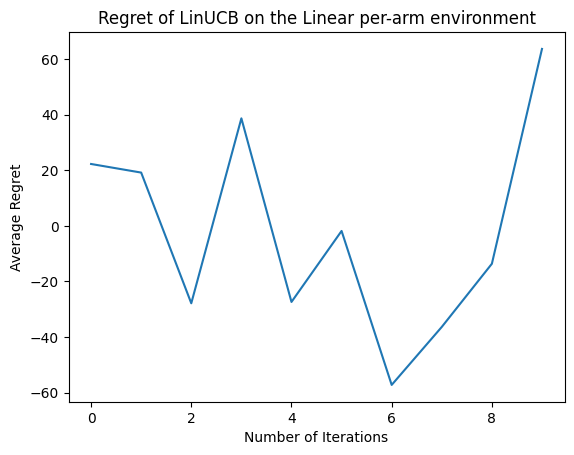

In [216]:
plt.plot(regret_values)
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')

#### TODO

In [ ]:
# elif FLAGS.agent == 'NeuralLinUCB':
# obs_spec = environment.observation_spec()
# network = (
#     global_and_arm_feature_network.create_feed_forward_common_tower_network(
#         obs_spec, (40, 30), (30, 40), (40, 20), ENCODING_DIM
#     )
# )
# agent = neural_linucb_agent.NeuralLinUCBAgent(
#     time_step_spec=environment.time_step_spec(),
#     action_spec=environment.action_spec(),
#     encoding_network=network,
#     encoding_network_num_train_steps=EPS_PHASE_STEPS,
#     encoding_dim=ENCODING_DIM,
#     optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
#     alpha=1.0,
#     gamma=1.0,
#     epsilon_greedy=EPSILON,
#     accepts_per_arm_features=True,
#     debug_summaries=True,
#     summarize_grads_and_vars=True,
#     emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
# )

# Ranking

In [21]:
global_dim = 9 
item_dim   = 11 
num_items  = 50
num_slots  = 3 
distance_threshold = 5.0 
batch_size = 128  

def global_sampling_fn():
    return np.random.randint(-1, 1, [global_dim]).astype(np.float32)

def item_sampling_fn():
    return np.random.randint(-2, 3, [item_dim]).astype(np.float32)

# Inner product with excess dimensions ignored.
scores_weight_matrix = np.eye(11, 9, dtype=np.float32)

In [22]:
global_sampling_fn()

array([-1., -1., -1.,  0., -1.,  0., -1.,  0., -1.], dtype=float32)

In [23]:
item_sampling_fn()

array([-1.,  0.,  0., -1.,  0.,  2.,  0., -2.,  0.,  0.,  1.],
      dtype=float32)

In [24]:
scores_weight_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)